In [1]:
import json
import math
import string
from datetime import UTC, datetime
from pathlib import Path
from uuid import UUID

import h5netcdf
import matplotlib.pyplot as plt
import mpltern
import numpy as np
import polars as pl
import shapely
import xarray as xr

In [2]:
DATETIME_START = datetime(2009, 1, 1, tzinfo=UTC)
DATETIME_STOP = datetime(2017, 1, 1, tzinfo=UTC)

In [3]:
DATAROOT = Path("../data")

datanames = [
    "era5l",
    "era5lnmp",
    "glofas",
    "glofas-mc",
    "grfr",
    "grfr-mc",
    "cnrd",
    # "cldasnmp",
]

labels = {
    "era5l": "ERA5-Land",
    "glofas": "GloFAS",
    "glofas-mc": "GloFAS-MC",
    "grfr": "GRFR",
    "grfr-mc": "GRFR-MC",
    "cnrd": "CNRD",
    "era5lnmp": "ERA5-Land/NoahMP",
    "cldasnmp": "CLDAS/NoahMP",
}

linecolors = {
    "era5l": "tab:blue",
    "glofas": "tab:orange",
    "glofas-mc": "tab:orange",
    "grfr": "tab:green",
    "grfr-mc": "tab:green",
    "cnrd": "tab:red",
    "era5lnmp": "tab:purple",
    "cldasnmp": "tab:brown",
}
linestyles = {
    "era5l": "-",
    "glofas": "-",
    "glofas-mc": "--",
    "grfr": "-",
    "grfr-mc": "--",
    "cnrd": "-",
    "era5lnmp": "-",
    "cldasnmp": "-",
}
markerstyles = {
    "era5l": "o",
    "glofas": "o",
    "glofas-mc": "+",
    "grfr": "o",
    "grfr-mc": "+",
    "cnrd": "o",
    "era5lnmp": "o",
    "cldasnmp": "o",
}

In [4]:
station: dict[UUID, tuple[float, float]] = {}
with open("../data/station.csv", "rt") as f:
    next(f)
    for line in f:
        sid, _name, _merit, _rid, lat_, lon_ = line.strip().split(",")
        station[UUID(sid)] = (float(lat_), float(lon_))

station_pinyin = {
    UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0"): "ZMD",
    UUID("urn:uuid:AC5B1300-C6EE-4395-A285-D77C6B3A1C95"): "BT",
    UUID("urn:uuid:2947AFEF-51B6-4B02-82F7-995D12185682"): "GT",
    UUID("urn:uuid:50CC5DFB-734F-4E67-A8F5-4095D0D72E85"): "BZL",
}

selected_stations = [
    UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0"),
    UUID("urn:uuid:2947AFEF-51B6-4B02-82F7-995D12185682"),
    UUID("urn:uuid:50CC5DFB-734F-4E67-A8F5-4095D0D72E85"),
]

labels = {
    "era5l": "ERA5-Land",
    "glofas": "GloFAS",
    "glofas-mc": "GloFAS-MC",
    "grfr": "GRFR",
    "grfr-mc": "GRFR-MC",
    "cnrd": "CNRD",
    "era5lnmp": "ERA5-Land/NoahMP",
    "cldasnmp": "CLDAS/NoahMP",
}

In [5]:
# plotting settings
FIGROOT = Path("../fig")
FIGDPI = 600
FIGSUFFIX = ".pdf"

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "savefig.pad_inches": 0.05 / 2.54,
        "grid.linewidth": 0.25,
        "axes.titlesize": 8,
        "axes.titlepad": 0.05,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "text.usetex": True,
    }
)

In [6]:
def plot_ucj(ax):
    ax.set_aspect("equal")
    ax.set_xlim(90.49, 100.22)
    ax.set_ylim(28.10, 35.83)
    ax.set_xticks(np.arange(92, 100.1, 2))
    ax.set_xticklabels([f"{x:.0f}°E" for x in np.arange(92, 100.1, 2)])
    ax.set_yticks(np.arange(29.0, 36, 1))
    ax.set_yticklabels([f"{x:.0f}°N" for x in np.arange(29.0, 36, 1)])


# Domain

In [7]:
def read_river_network(filepath: Path):
    rivers: dict[UUID, shapely.LineString] = {}
    downstreams: dict[UUID, UUID | None] = {}
    river_index: dict[int, UUID] = {}
    river_to_index: dict[UUID, int] = {}
    with open(filepath, "r") as f:
        for line in f:
            feature = json.loads(line)
            rid = UUID(feature["properties"]["uuid"])
            river_index[int(feature["properties"]["linkid"])] = rid
            river_to_index[rid] = int(feature["properties"]["to"] or -1)
            geom = shapely.geometry.shape(feature["geometry"])
            rivers[rid] = geom
    for rid, to in river_to_index.items():
        if to != -1:
            downstreams[rid] = river_index[to]
        else:
            downstreams[rid] = None
    return rivers, downstreams


rivers, downstreams = read_river_network(DATAROOT.joinpath("river_network.geojsonl"))

In [8]:
with h5netcdf.File(DATAROOT.joinpath("setup.nc"), "r") as f:
    lat = np.array(f.variables["south_north"][:], np.float64)
    lon = np.array(f.variables["west_east"][:], np.float64)
    hgt = np.array(f.variables["HGT"][:], np.float32)
    mask = np.array(f.variables["XLAND"][:] == 1, np.bool)

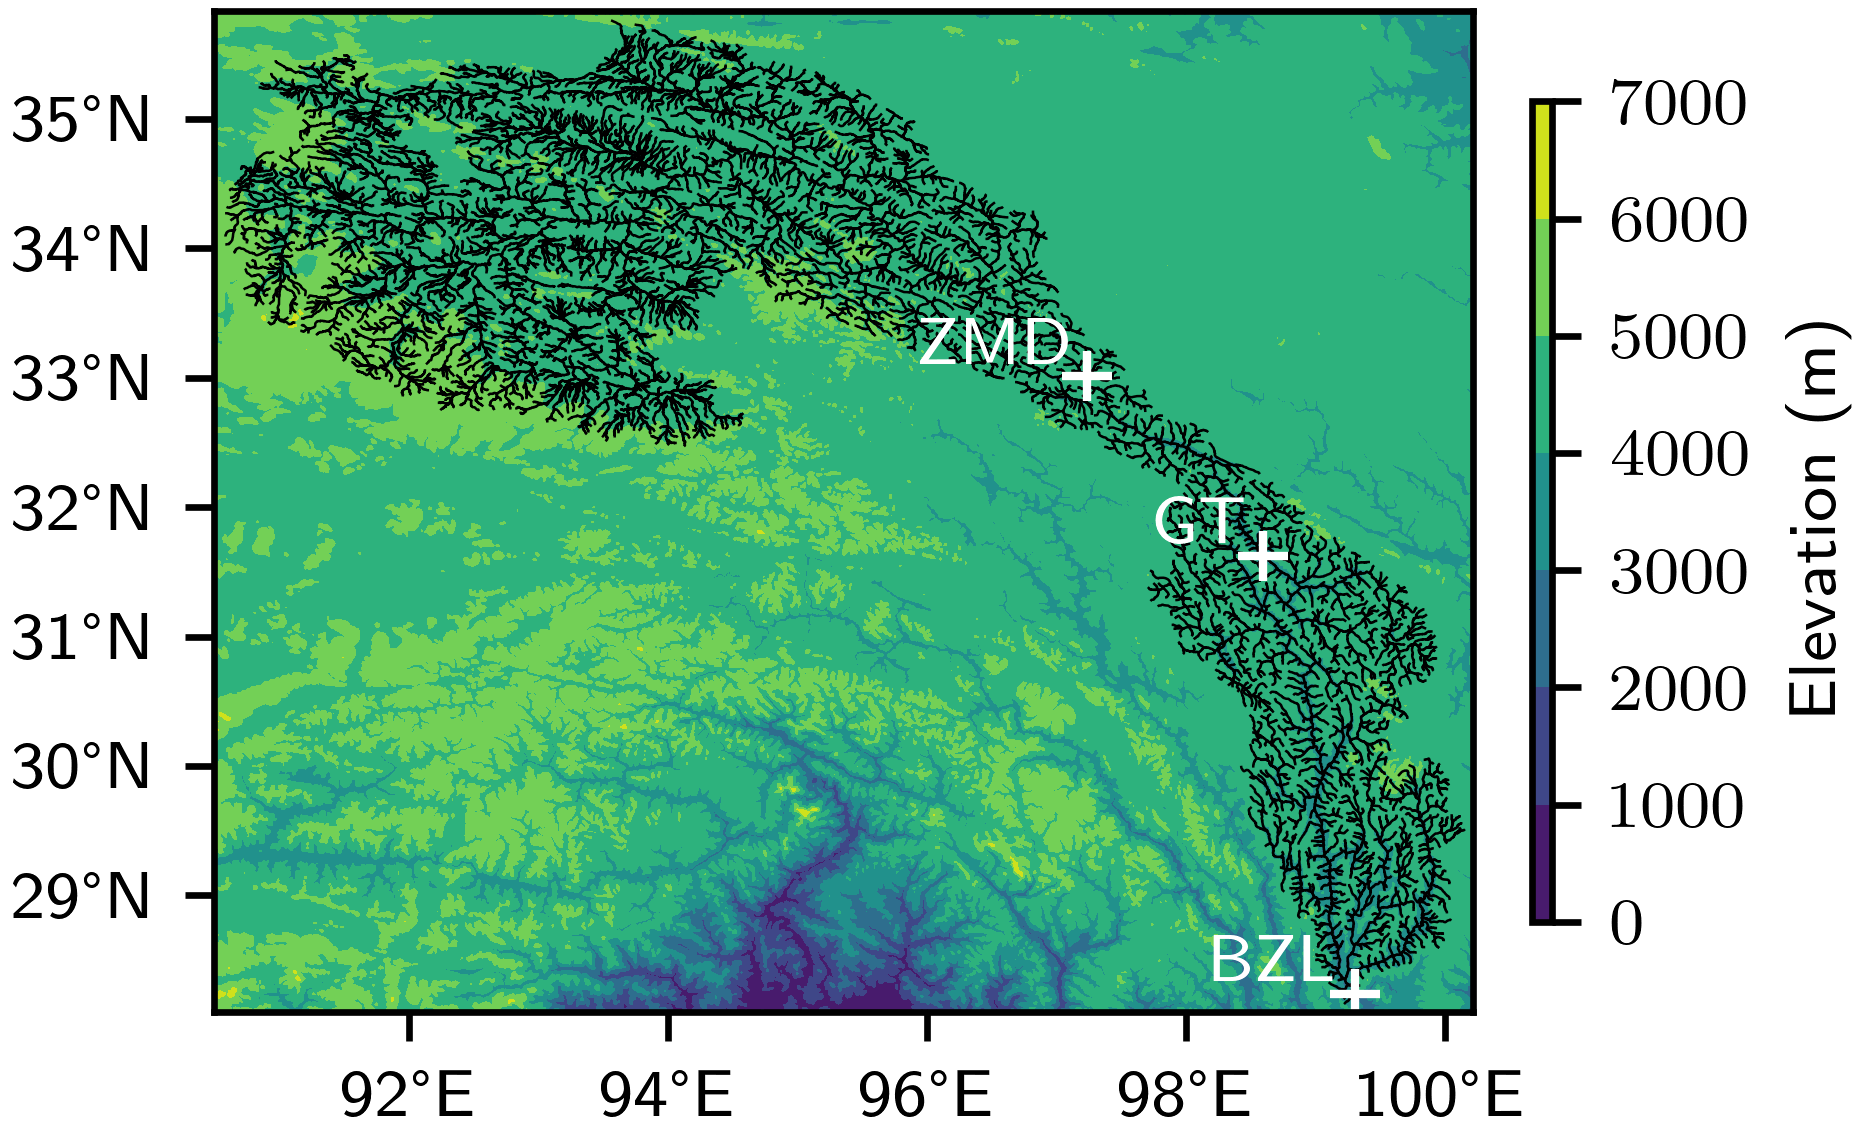

In [9]:
fig = plt.figure(figsize=(8 / 2.54, 6 / 2.54), dpi=FIGDPI, layout="constrained")
ax = fig.add_subplot(111)

cf = ax.contourf(lon, lat, hgt)

for ll in rivers.values():
    ax.plot(*ll.xy, color="black", linewidth=0.3)

for sid in selected_stations:
    lat_, lon_ = station[sid]
    ax.plot(lon_, lat_, "+", color="white", markersize=6)
    ax.text(
        lon_ - 0.1,
        lat_,
        station_pinyin[sid],
        color="white",
        fontsize=8,
        ha="right",
        va="bottom",
    )

plot_ucj(ax)
plt.colorbar(cf, ax=ax, label="Elevation (m)", shrink=0.6, pad=0.001, aspect=40)

fig.savefig(FIGROOT.joinpath("domain").with_suffix(FIGSUFFIX), bbox_inches="tight")

# Multi-year averaged runoff

In [10]:
YRMEAN_FILE = DATAROOT.joinpath("runoff_yrmean.nc")
runoff_yrmean = xr.open_dataset(YRMEAN_FILE)

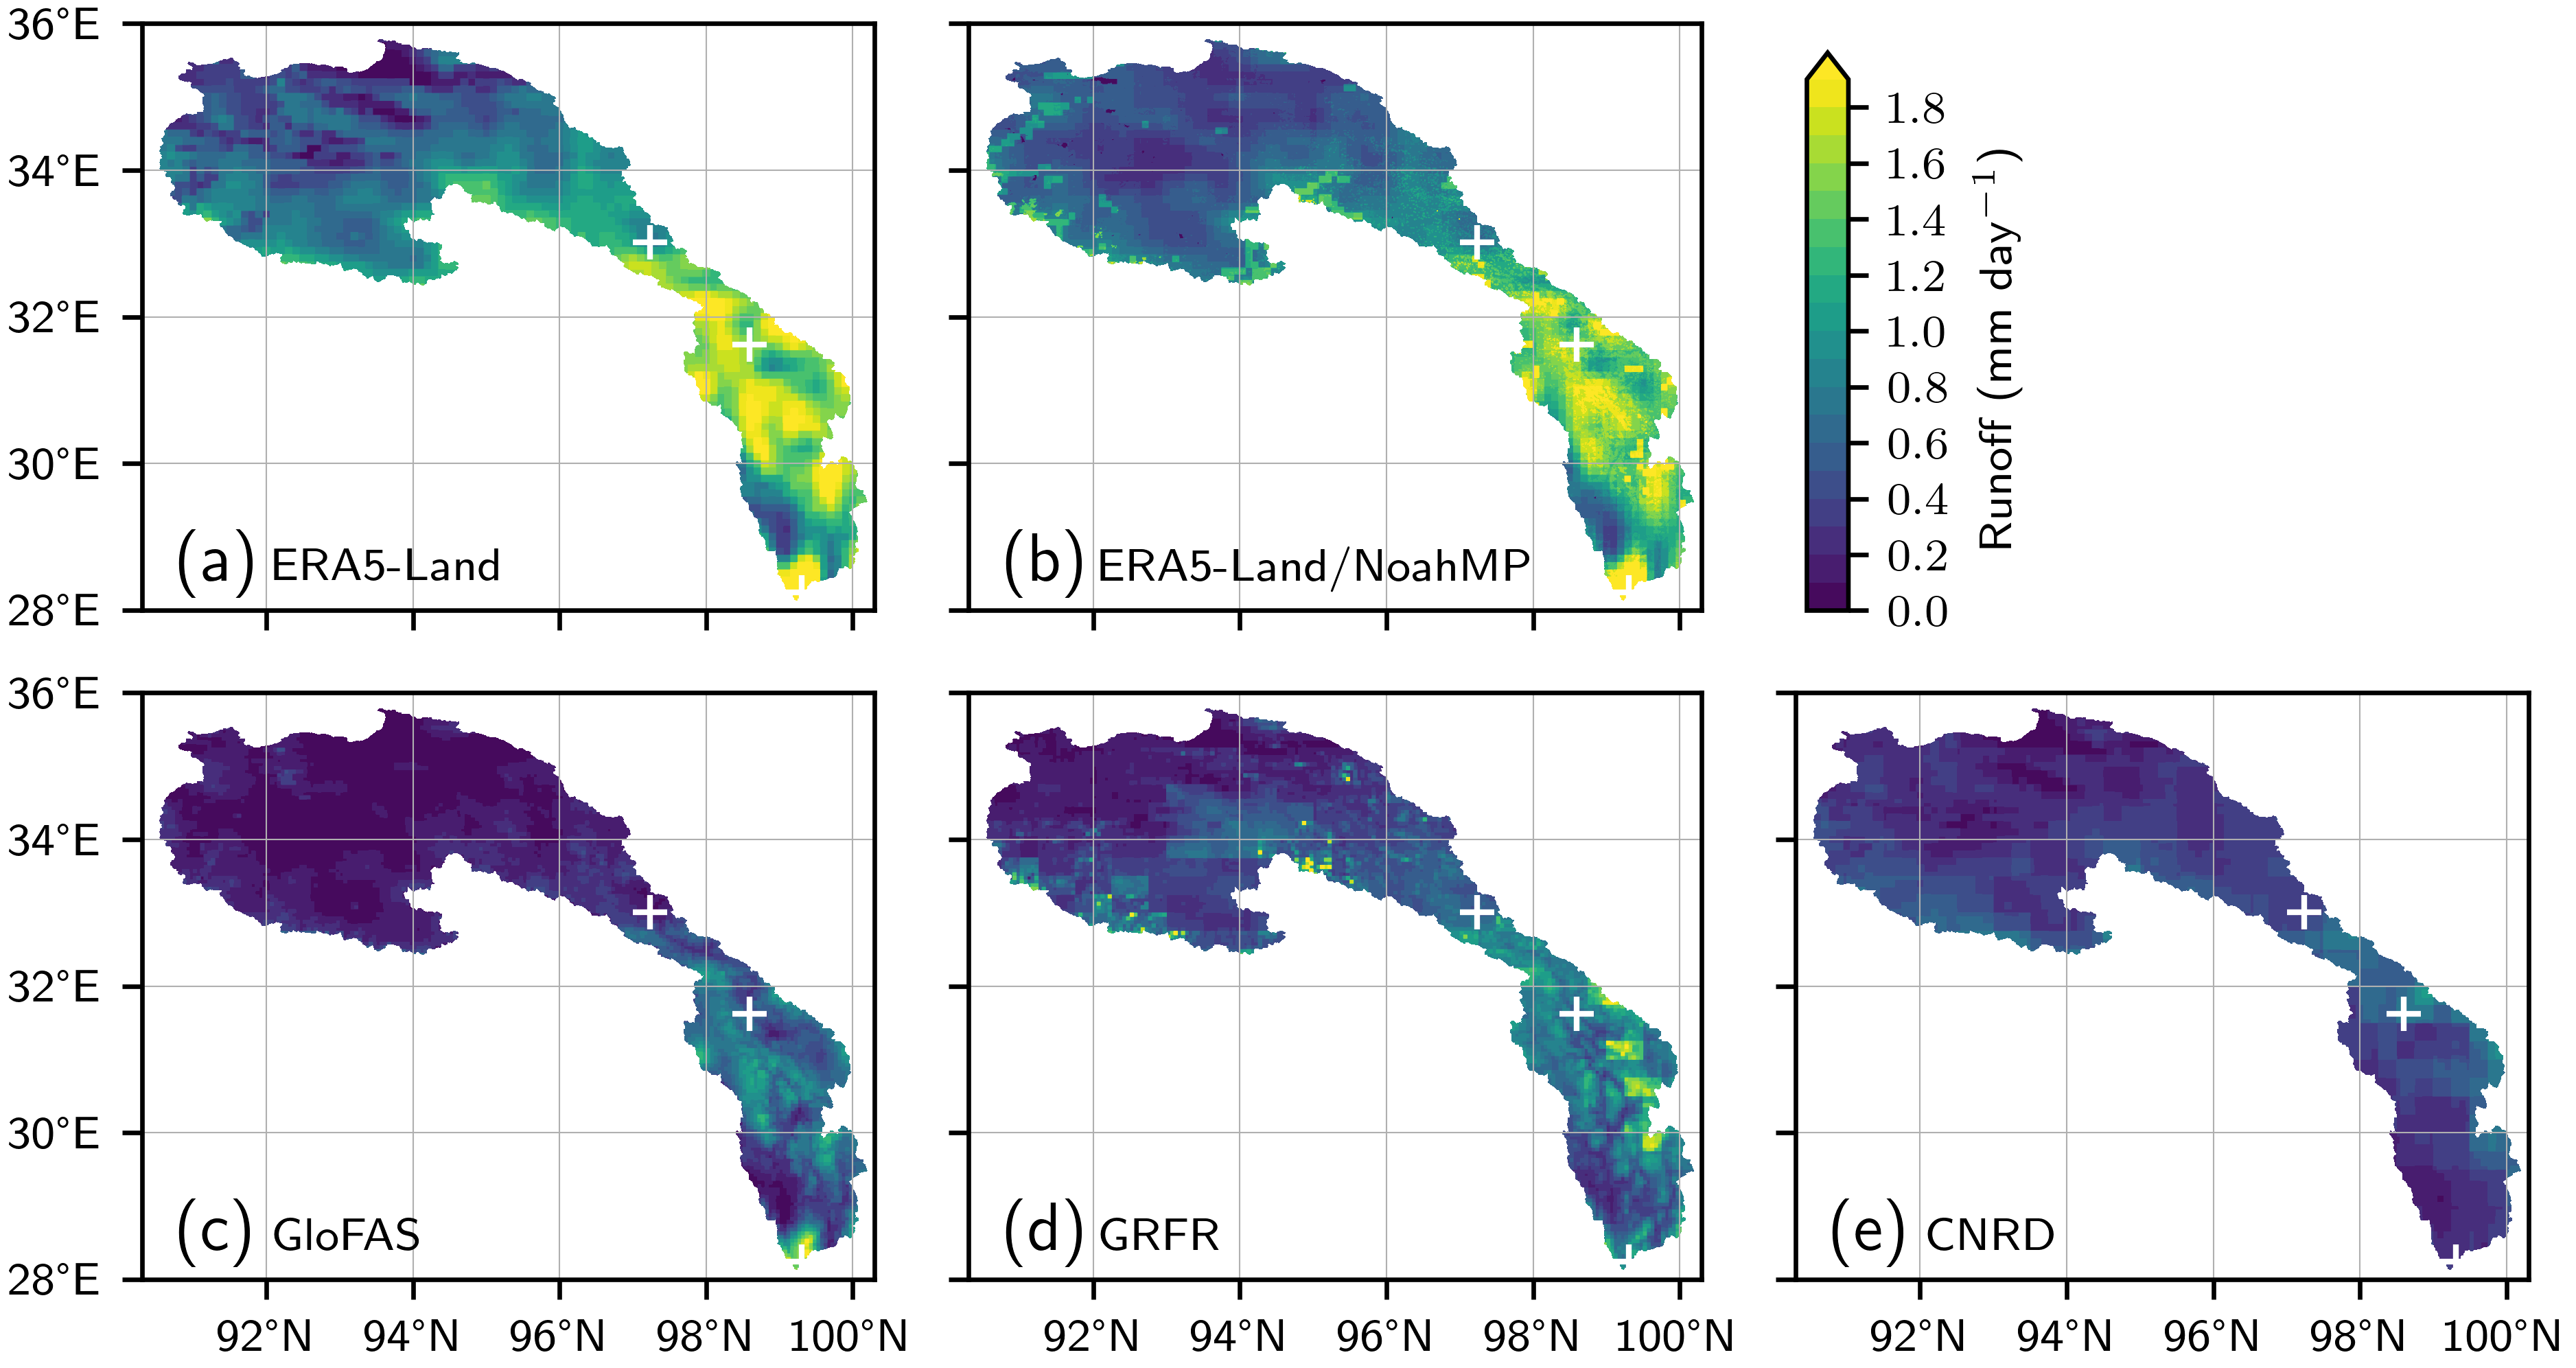

In [11]:
fig = plt.figure(figsize=(16 / 2.54, 8.6 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(2, 3, sharex=True, sharey=True, squeeze=False)

levels = np.arange(0, 2.0, 0.1)

axs_map = {
    "era5l": axs[0, 0],
    "era5lnmp": axs[0, 1],
    "glofas": axs[1, 0],
    "grfr": axs[1, 1],
    "cnrd": axs[1, 2],
}

for i, dsn in enumerate(axs_map.keys()):
    ax = axs_map[dsn]
    cf = ax.contourf(
        runoff_yrmean["lon"],
        runoff_yrmean["lat"],
        (runoff_yrmean[dsn]) * (3600 * 24),
        levels=levels,
        extend="max",
    )
    ax.text(
        0.05,
        0.05,
        f"({string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        ha="left",
        va="baseline",
        fontsize=12,
    )
    ax.text(
        0.18,
        0.05,
        f"{labels[dsn]}",
        transform=ax.transAxes,
        ha="left",
        va="baseline",
        fontsize=8,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect("equal")
    ax.grid(True)

    for sid in selected_stations:
        lat_, lon_ = station[sid]
        ax.plot(lon_, lat_, "+", color="white", markersize=6)

axs[0, 0].set_yticks([28, 30, 32, 34, 36])
axs[0, 0].set_yticklabels(["28°E", "30°E", "32°E", "34°E", "36°E"])
axs[0, 0].set_ylim([28.0, 36])
axs[0, 0].set_xticks([92, 94, 96, 98, 100])
axs[0, 0].set_xticklabels(["92°N", "94°N", "96°N", "98°N", "100°N"])
axs[0, 0].set_xlim([90.3, 100.3])

axs[0, 2].set_visible(False)

cb = fig.colorbar(
    cf,
    cax=plt.axes((0.7, 0.55, 0.016, 0.4)),
    orientation="vertical",
    # pad=0.05,
    # aspect=50,
    # shrink=0.6,
)
cb.set_label("Runoff (mm day$^{-1}$)")

fig.savefig(FIGROOT.joinpath("runoff_mean").with_suffix(FIGSUFFIX), bbox_inches="tight")

# Runoff and Discharge

## Read the data

In [12]:
qobs = pl.read_parquet(DATAROOT.joinpath("discharge_observation.parquet")).filter(
    (pl.col("datetime") >= DATETIME_START) & (pl.col("datetime") <= DATETIME_STOP)
)

In [13]:
rsim: dict[str, pl.DataFrame] = {}
for dataname in datanames:
    filepath = DATAROOT.joinpath("discharge_atgauge", f"{dataname}_passthrough.parquet")
    if not filepath.exists():
        continue
    rsim[dataname] = pl.read_parquet(filepath).filter(
        (pl.col("datetime") >= DATETIME_START) & (pl.col("datetime") <= DATETIME_STOP)
    )

In [14]:
qsim: dict[str, pl.DataFrame] = {}
for dataname in datanames:
    filepath = DATAROOT.joinpath("discharge_atgauge", f"{dataname}.parquet")
    if not filepath.exists():
        continue
    qsim[dataname] = pl.read_parquet(filepath).filter(
        (pl.col("datetime") >= DATETIME_START) & (pl.col("datetime") <= DATETIME_STOP)
    )

In [15]:
qobsmon = (
    qobs.group_by_dynamic(
        "datetime", every="1mo", period="1mo", closed="right", label="left"
    )
    .agg(pl.all().exclude("datetime").mean())
    .filter(pl.col("datetime") >= DATETIME_START)
)


In [16]:
qobsday = (
    qobs.group_by_dynamic(
        "datetime", every="1d", period="1d", closed="right", label="left"
    )
    .agg(pl.all().exclude("datetime").mean())
    .filter(pl.col("datetime") >= DATETIME_START)
)


In [17]:
rsimmon: dict[str, pl.DataFrame] = {}
for dataname, crsim in rsim.items():
    rsimmon[dataname] = (
        crsim.group_by_dynamic(
            "datetime",
            every="1mo",
            period="1mo",
            closed="right",
            label="left",
        )
        .agg(pl.all().exclude("datetime").mean())
        .filter(pl.col("datetime") >= DATETIME_START)
    )


In [18]:
rsimday: dict[str, pl.DataFrame] = {}
for dataname, crsim in rsim.items():
    rsimday[dataname] = (
        crsim.group_by_dynamic(
            "datetime",
            every="1d",
            period="1d",
            closed="right",
            label="left",
        )
        .agg(pl.all().exclude("datetime").mean())
        .filter(pl.col("datetime") >= DATETIME_START)
    )


In [19]:
qsimmon: dict[str, pl.DataFrame] = {}
for dataname, cqsim in qsim.items():
    qsimmon[dataname] = (
        cqsim.group_by_dynamic(
            "datetime",
            every="1mo",
            period="1mo",
            closed="right",
            label="left",
        )
        .agg(pl.all().exclude("datetime").mean())
        .filter(pl.col("datetime") >= DATETIME_START)
    )

In [20]:
qsimday: dict[str, pl.DataFrame] = {}
for dataname, cqsim in qsim.items():
    qsimday[dataname] = (
        cqsim.group_by_dynamic(
            "datetime",
            every="1d",
            period="1d",
            closed="right",
            label="left",
        )
        .agg(pl.all().exclude("datetime").mean())
        .filter(pl.col("datetime") >= DATETIME_START)
    )

In [21]:
for stn in selected_stations:
    print(station_pinyin[stn], qobs["datetime", stn.urn].drop_nulls().height)

ZMD 1553
GT 52246
BZL 69011


## Runoff Figures

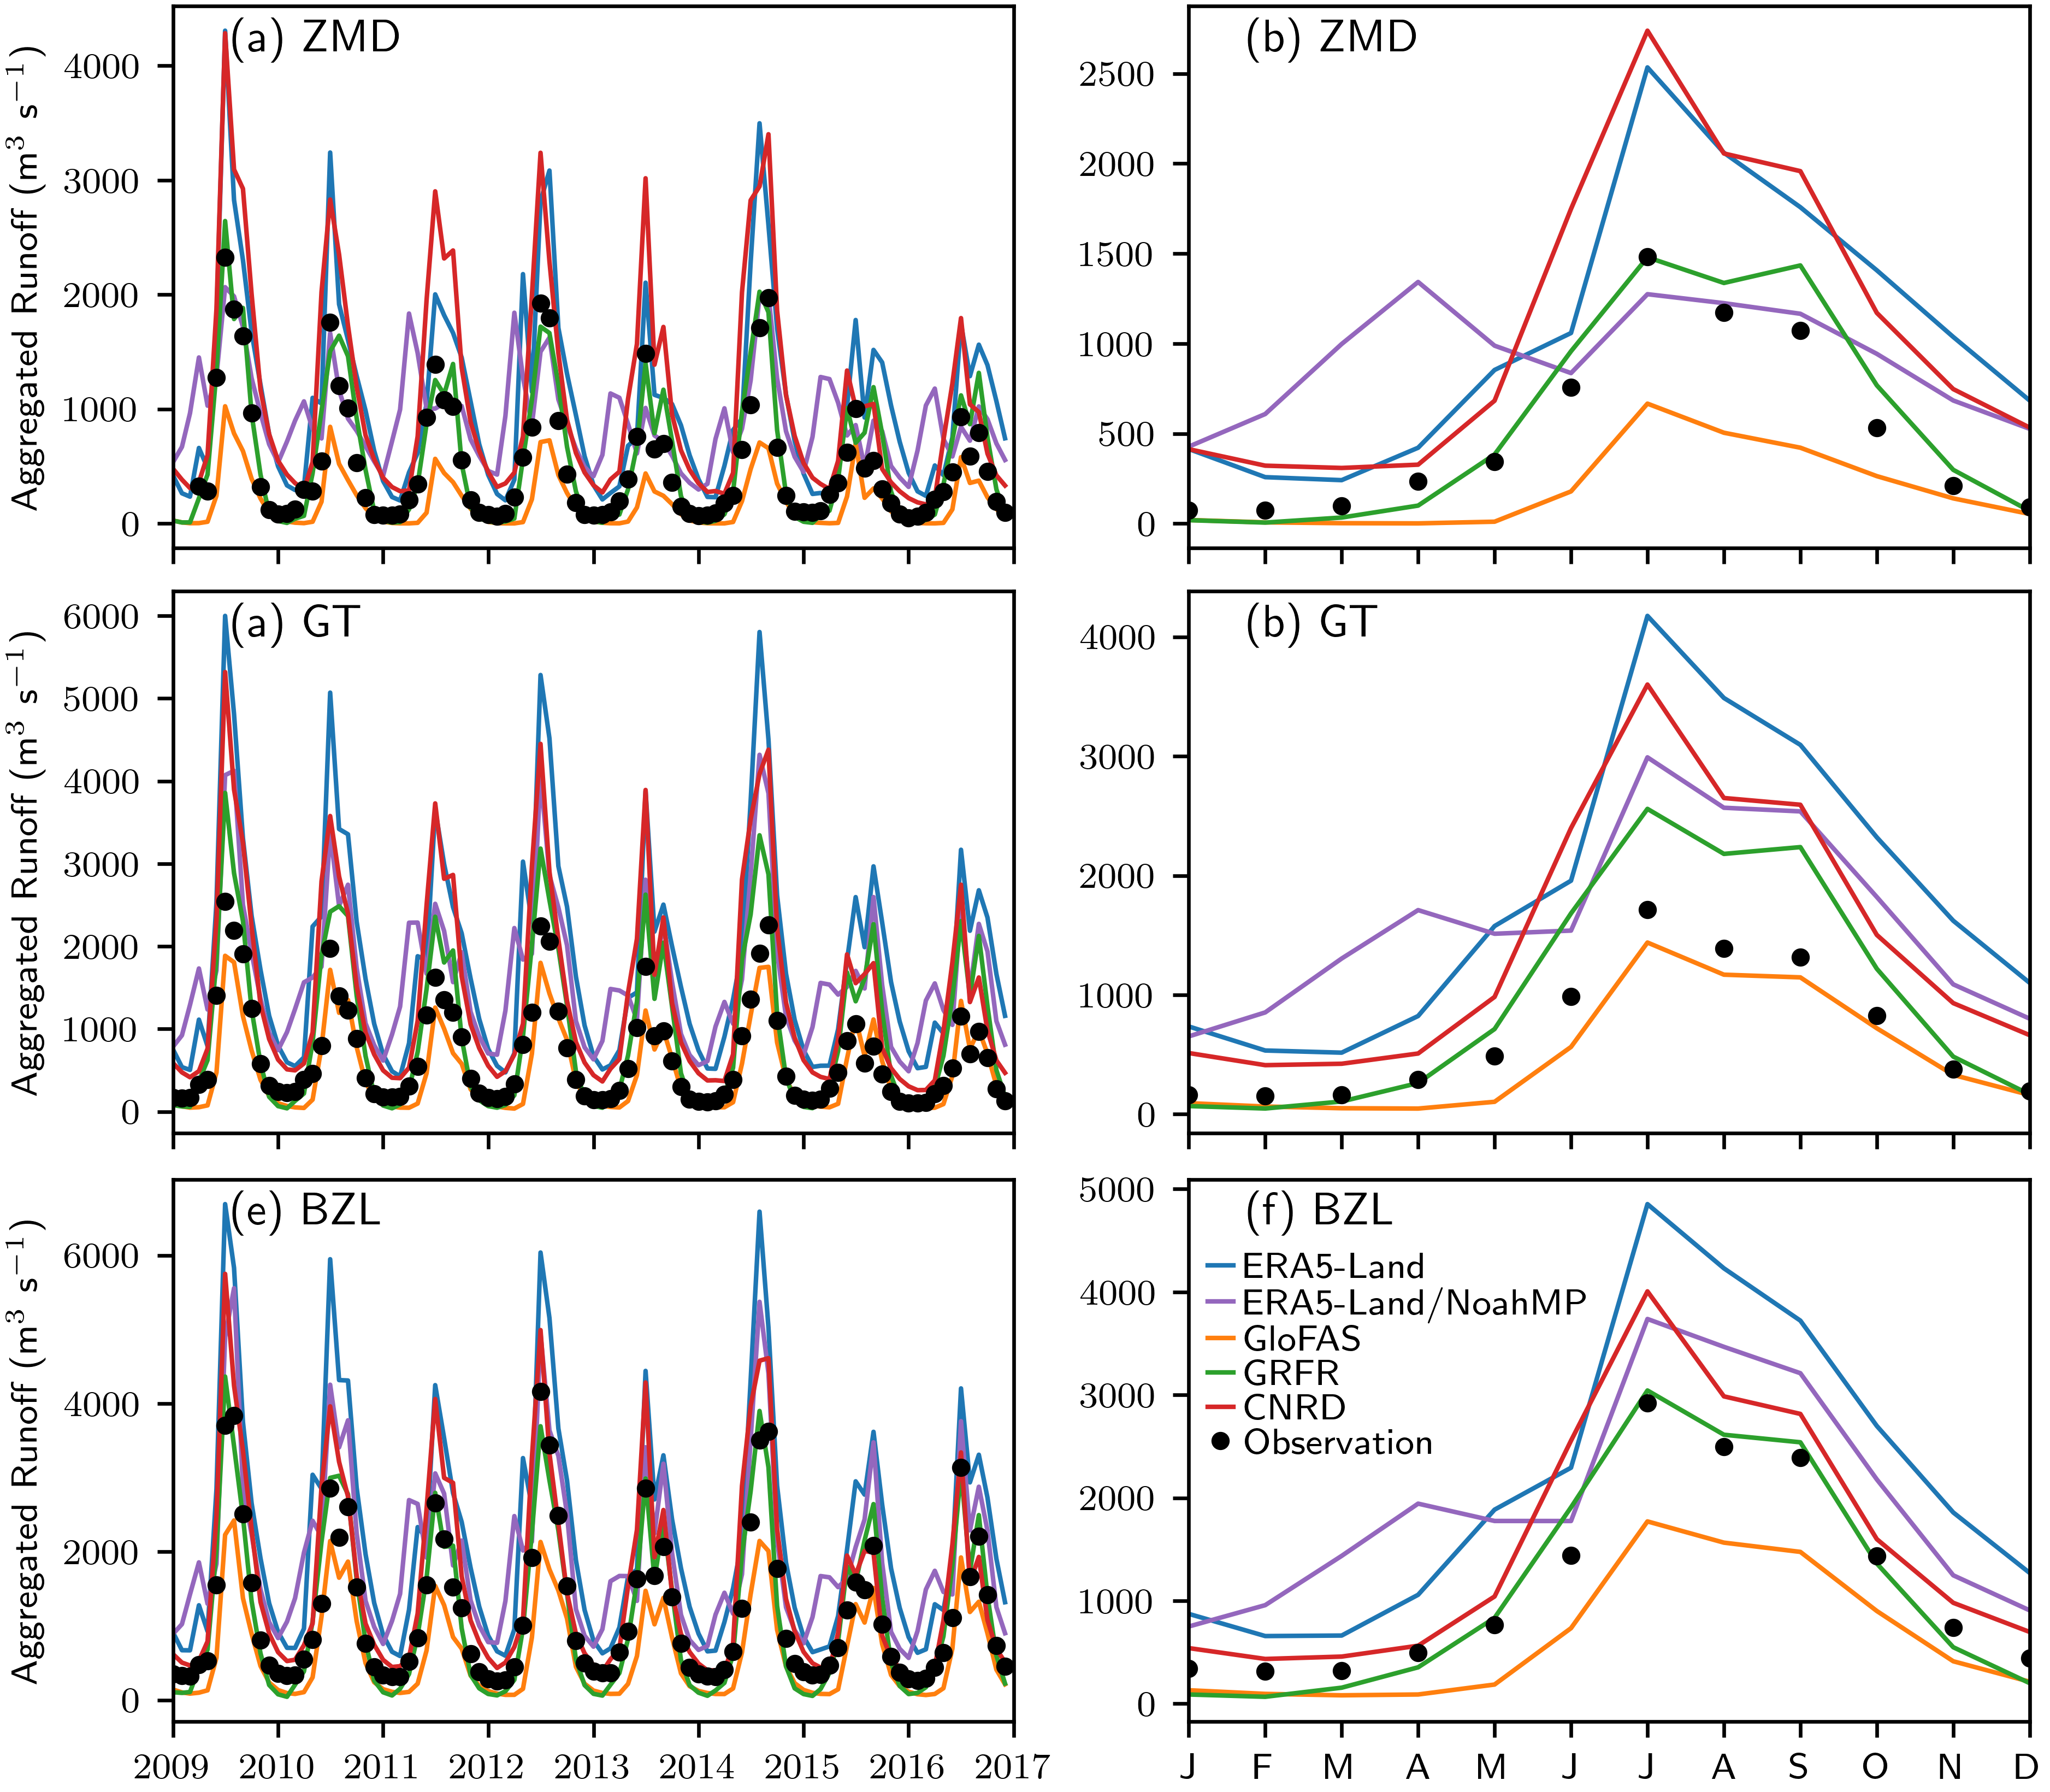

In [22]:
fig = plt.figure(figsize=(16 / 2.54, 14 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 2)

ax = axs[0, 0]

station = selected_stations[0]

for dataname, data in rsimmon.items():
    xy = data.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = qobsmon.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_ylabel("Aggregated Runoff (m$^3$ s$^{-1}$)")
ax.set_xlim(DATETIME_START, DATETIME_STOP)
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(a) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[0, 1]

for dataname, data in rsimmon.items():
    xy = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .group_by(pl.col("datetime").dt.month())
        .agg(pl.col(station.urn).mean())
    ).sort("datetime")
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = (
    qobsmon.select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .group_by(pl.col("datetime").dt.month())
    .agg(pl.col(station.urn).mean())
).sort("datetime")
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(b) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[1, 0]

station = selected_stations[1]

for dataname, data in rsimmon.items():
    xy = data.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = qobsmon.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_ylabel("Aggregated Runoff (m$^3$ s$^{-1}$)")
ax.set_xlim(DATETIME_START, DATETIME_STOP)
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(a) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[1, 1]

for dataname, data in rsimmon.items():
    xy = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .group_by(pl.col("datetime").dt.month())
        .agg(pl.col(station.urn).mean())
    ).sort("datetime")
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = (
    qobsmon.select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .group_by(pl.col("datetime").dt.month())
    .agg(pl.col(station.urn).mean())
).sort("datetime")
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(b) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[2, 0]

station = selected_stations[2]

for dataname, data in rsimmon.items():
    xy = data.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = qobsmon.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_ylabel("Aggregated Runoff (m$^3$ s$^{-1}$)")
ax.set_xlim(DATETIME_START, DATETIME_STOP)

ax.text(
    0.07,
    0.98,
    f"(e) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[2, 1]

for dataname, data in rsimmon.items():
    xy = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .group_by(pl.col("datetime").dt.month())
        .agg(pl.col(station.urn).mean())
    ).sort("datetime")
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = (
    qobsmon.select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .group_by(pl.col("datetime").dt.month())
    .agg(pl.col(station.urn).mean())
).sort("datetime")
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels("JFMAMJJASOND")

ax.text(
    0.07,
    0.98,
    f"(f) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 0.9),
    frameon=False,
    borderpad=0.02,
    labelspacing=0.05,
    handlelength=0.7,
    handletextpad=0.3,
)

fig.savefig(
    FIGROOT.joinpath("runoff_agg_ts").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

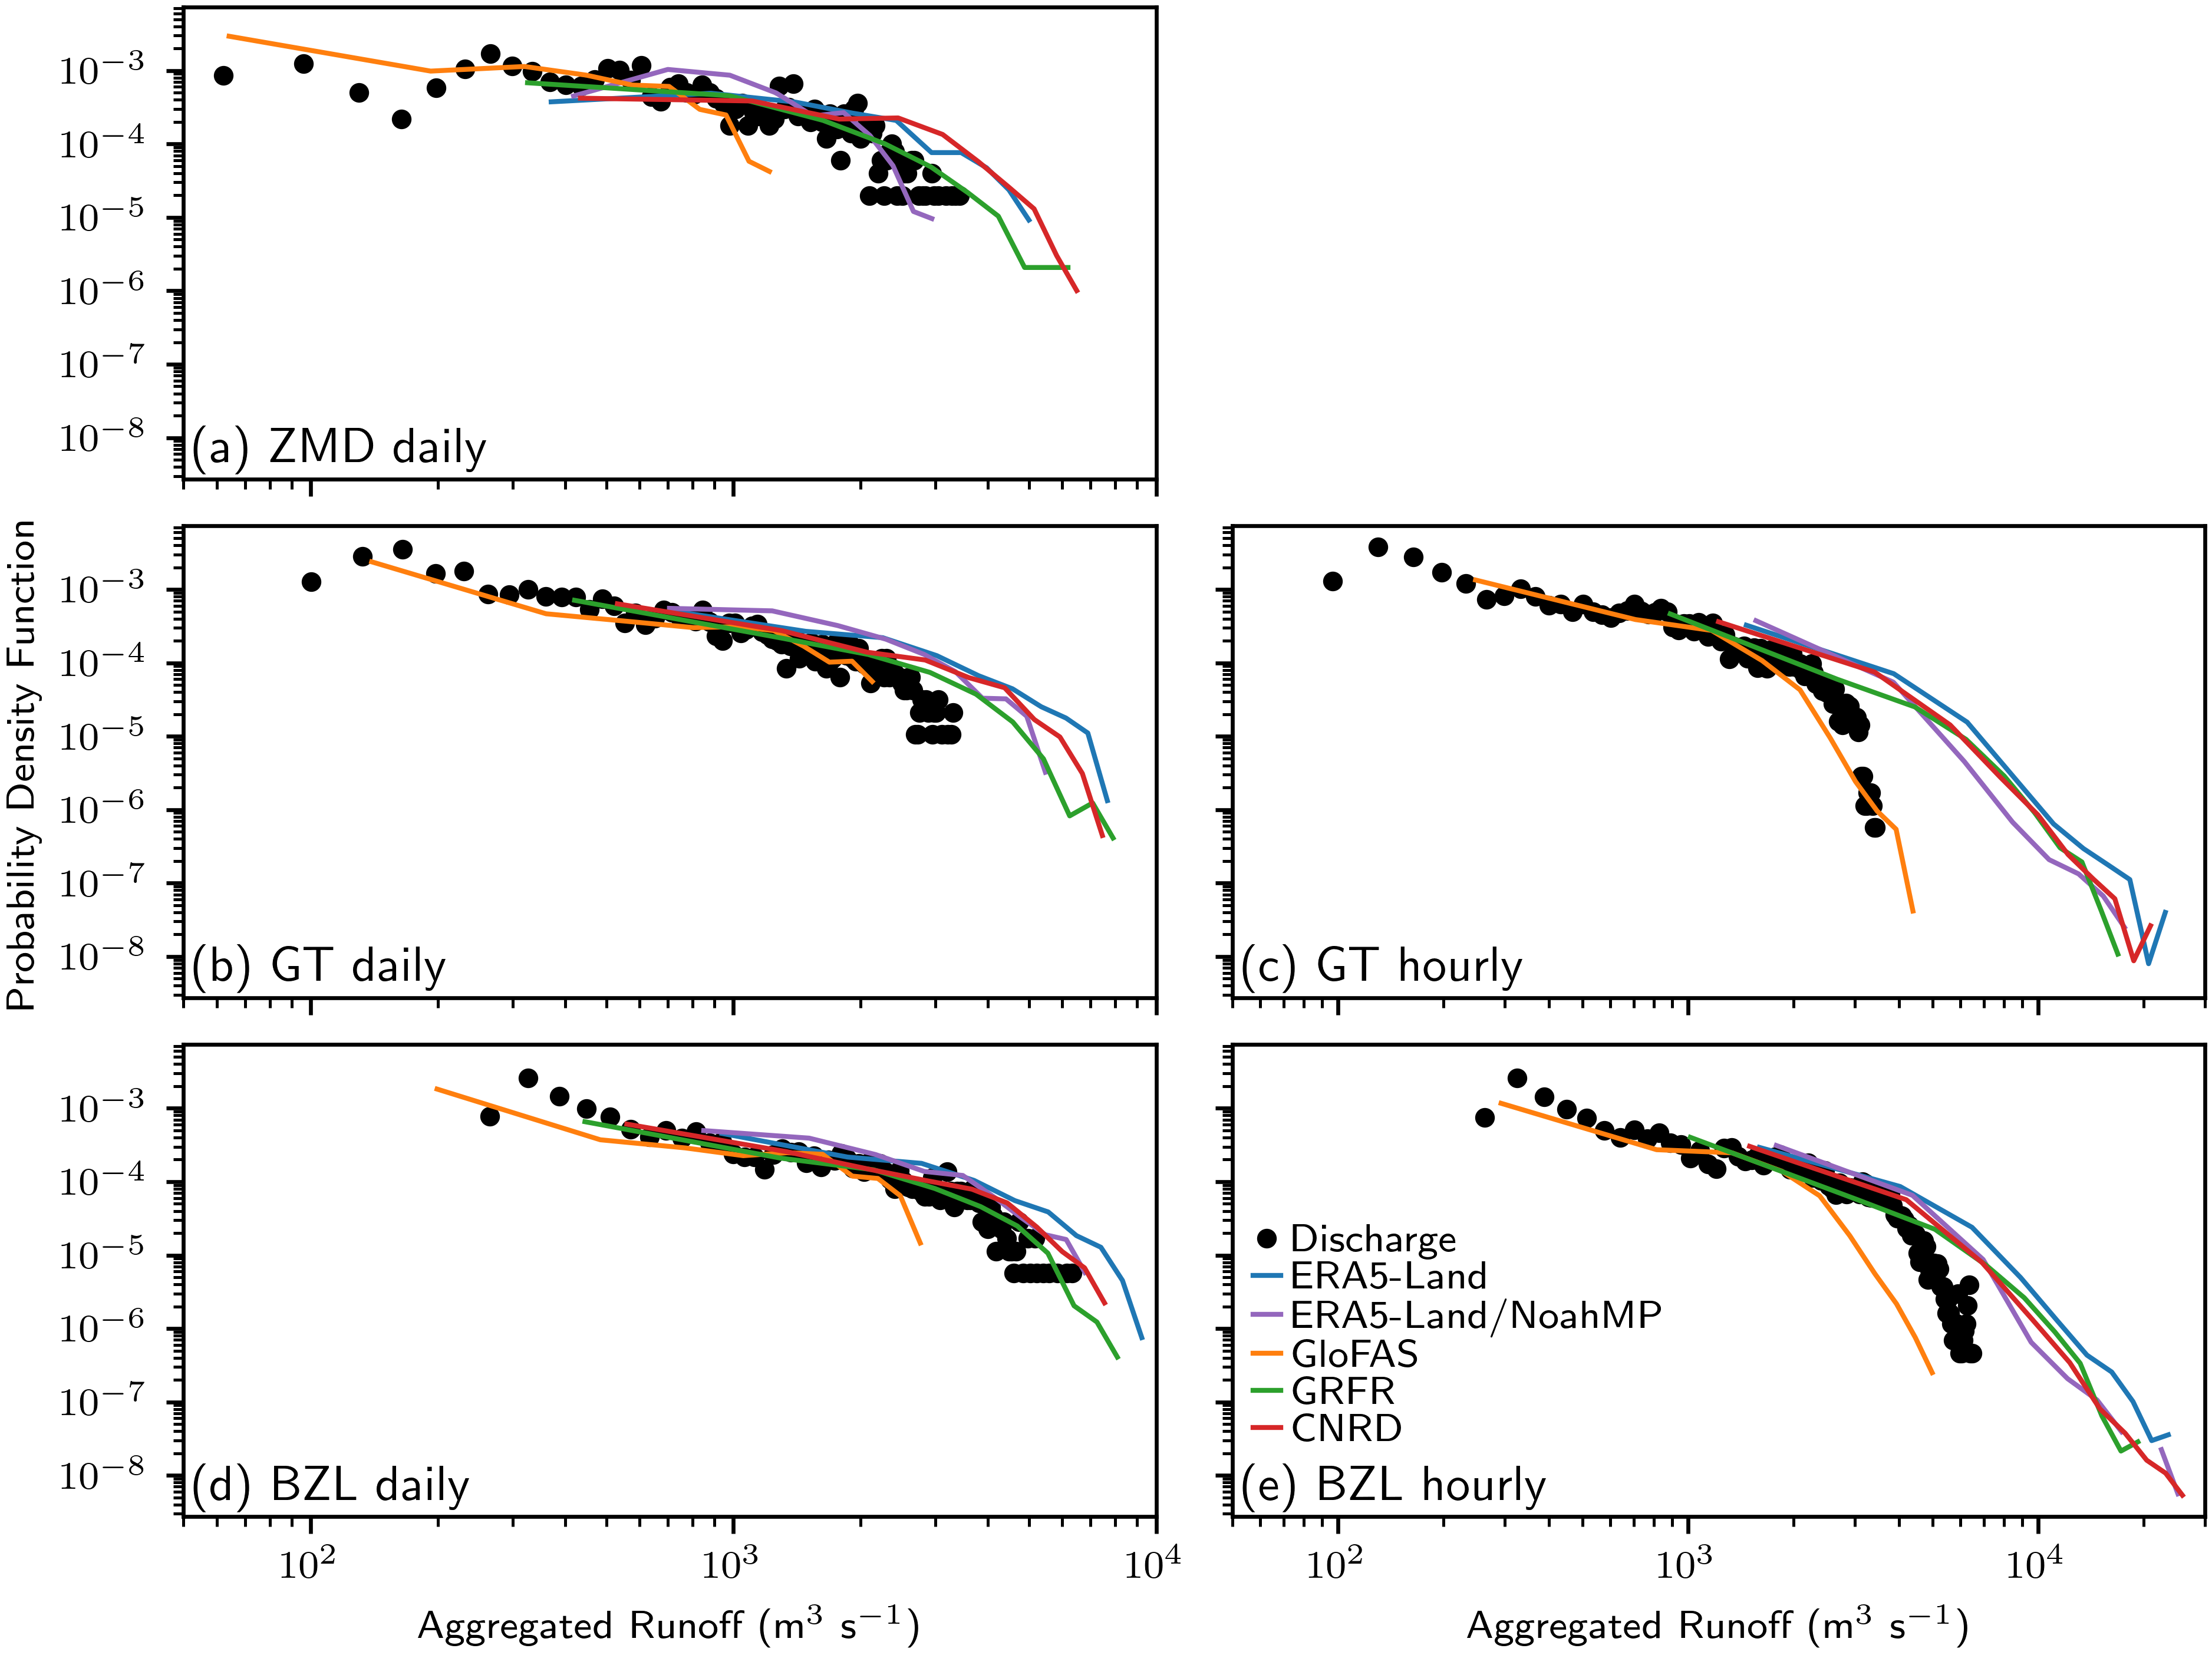

In [23]:
fig = plt.figure(figsize=(16 / 2.54, 12 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 2, sharey=True)

daily_range = (50, 1e4)
hourly_range = (50, 3e4)

ax = axs[0, 0]
station = selected_stations[0]

xyz = (
    rsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Discharge")


for dataname, data in rsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(daily_range)
ax.text(
    0.01,
    0.01,
    f"(a) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[0, 1]

xyz = (
    rsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Discharge")

for dataname, data in rsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(hourly_range)
ax.text(
    0.01,
    0.01,
    f"(b) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)

ax.set_visible(False)

ax = axs[1, 0]
station = selected_stations[1]

xyz = (
    rsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Discharge")


for dataname, data in rsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(daily_range)
ax.set_ylabel("Probability Density Function")
ax.text(
    0.01,
    0.01,
    f"(b) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[1, 1]

xyz = (
    rsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Discharge")

for dataname, data in rsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(hourly_range)
ax.text(
    0.01,
    0.01,
    f"(c) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[2, 0]
station = selected_stations[2]

xyz = (
    rsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Discharge")

for dataname, data in rsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(daily_range)
ax.set_xlabel("Aggregated Runoff (m$^3$ s$^{-1}$)")
ax.text(
    0.01,
    0.01,
    f"(d) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[2, 1]

xyz = (
    rsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Discharge")

for dataname, data in rsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(hourly_range)
ax.set_xlabel("Aggregated Runoff (m$^3$ s$^{-1}$)")
ax.text(
    0.01,
    0.01,
    f"(e) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax.legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 0.1),
    frameon=False,
    borderpad=0.02,
    labelspacing=0.05,
    handlelength=0.7,
    handletextpad=0.3,
)


fig.savefig(
    FIGROOT.joinpath("runoff_agg_dist").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

## Discharge Figures

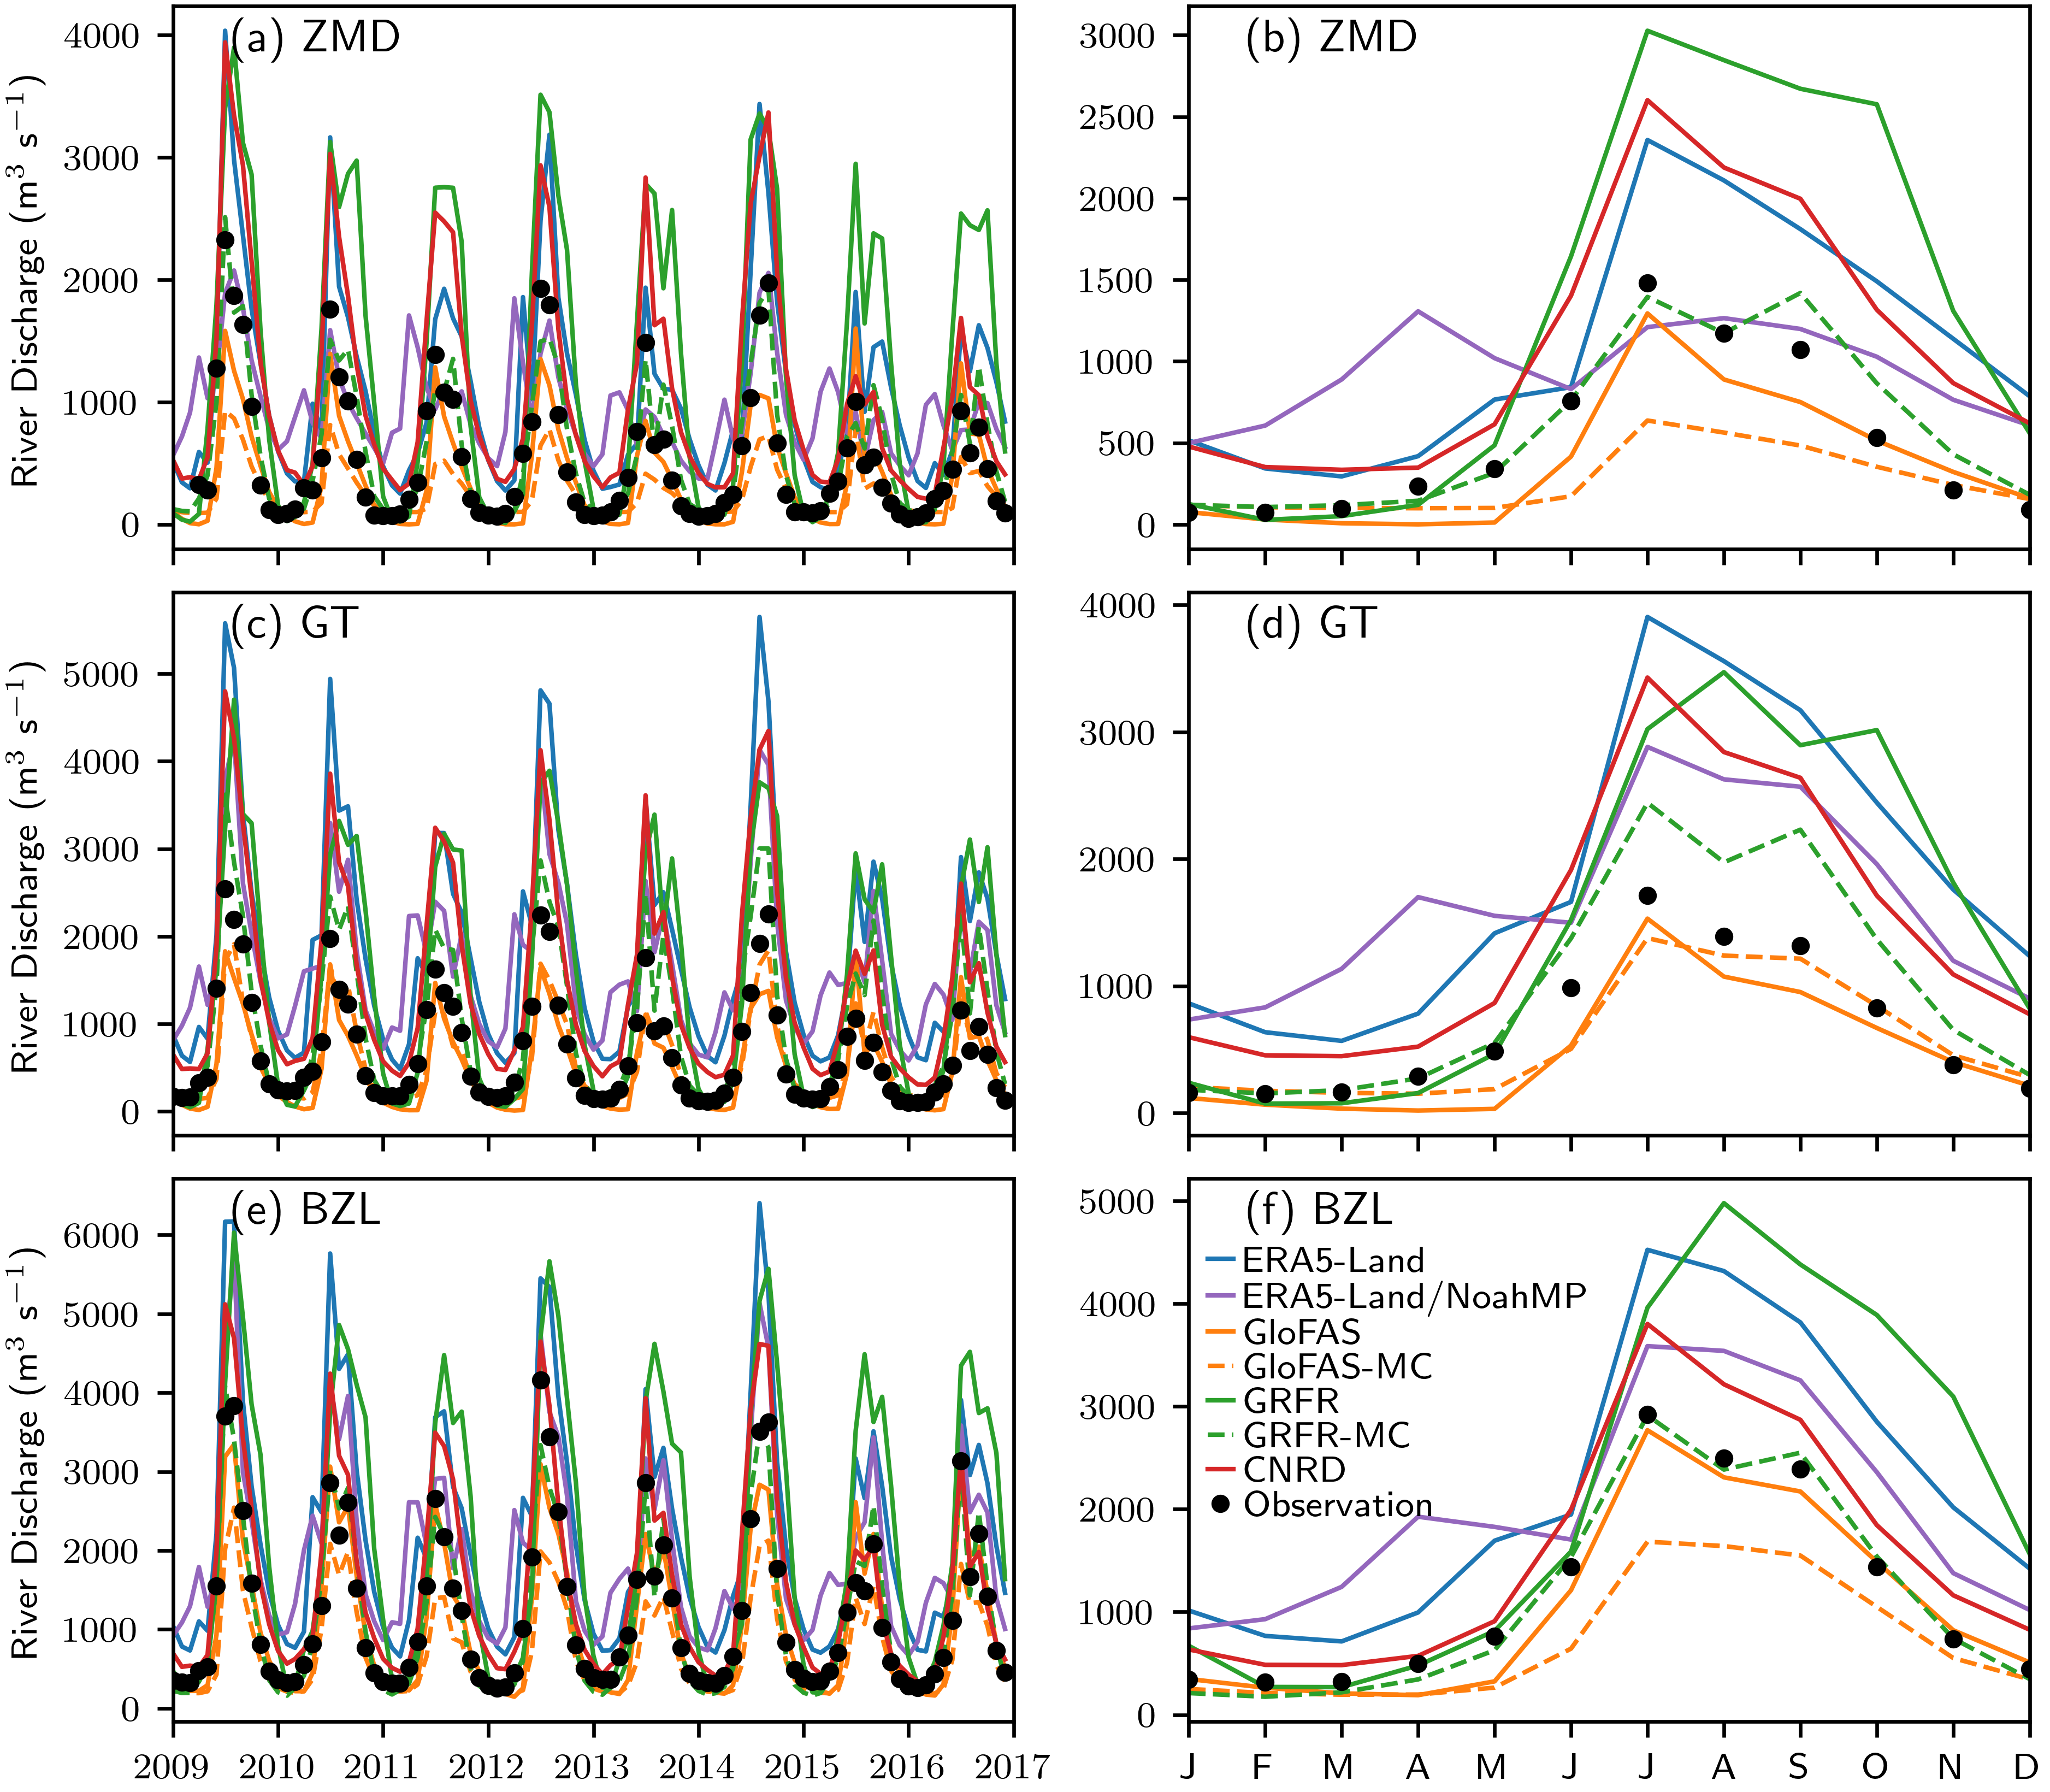

In [24]:
fig = plt.figure(figsize=(16 / 2.54, 14 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 2)

ax = axs[0, 0]

station = selected_stations[0]

for dataname, data in qsimmon.items():
    xy = data.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = qobsmon.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_ylabel("River Discharge (m$^3$ s$^{-1}$)")
ax.set_xlim(DATETIME_START, DATETIME_STOP)
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(a) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[0, 1]

for dataname, data in qsimmon.items():
    xy = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .group_by(pl.col("datetime").dt.month())
        .agg(pl.col(station.urn).mean())
    ).sort("datetime")
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = (
    qobsmon.select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .group_by(pl.col("datetime").dt.month())
    .agg(pl.col(station.urn).mean())
).sort("datetime")
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(b) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[1, 0]

station = selected_stations[1]

for dataname, data in qsimmon.items():
    xy = data.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = qobsmon.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_ylabel("River Discharge (m$^3$ s$^{-1}$)")
ax.set_xlim(DATETIME_START, DATETIME_STOP)
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(c) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[1, 1]

for dataname, data in qsimmon.items():
    xy = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .group_by(pl.col("datetime").dt.month())
        .agg(pl.col(station.urn).mean())
    ).sort("datetime")
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = (
    qobsmon.select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .group_by(pl.col("datetime").dt.month())
    .agg(pl.col(station.urn).mean())
).sort("datetime")
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels("")

ax.text(
    0.07,
    0.98,
    f"(d) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[2, 0]

station = selected_stations[2]

for dataname, data in qsimmon.items():
    xy = data.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = qobsmon.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls()
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_ylabel("River Discharge (m$^3$ s$^{-1}$)")
ax.set_xlim(DATETIME_START, DATETIME_STOP)

ax.text(
    0.07,
    0.98,
    f"(e) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[2, 1]

for dataname, data in qsimmon.items():
    xy = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .group_by(pl.col("datetime").dt.month())
        .agg(pl.col(station.urn).mean())
    ).sort("datetime")
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

xy = (
    qobsmon.select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .group_by(pl.col("datetime").dt.month())
    .agg(pl.col(station.urn).mean())
).sort("datetime")
ax.plot(xy[:, 0], xy[:, 1], "k.", label="Observation")

ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels("JFMAMJJASOND")

ax.text(
    0.07,
    0.98,
    f"(f) {station_pinyin[station]}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 0.91),
    frameon=False,
    borderpad=0.02,
    labelspacing=0.05,
    handlelength=0.7,
    handletextpad=0.3,
)

fig.savefig(
    FIGROOT.joinpath("streamflow_ts").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

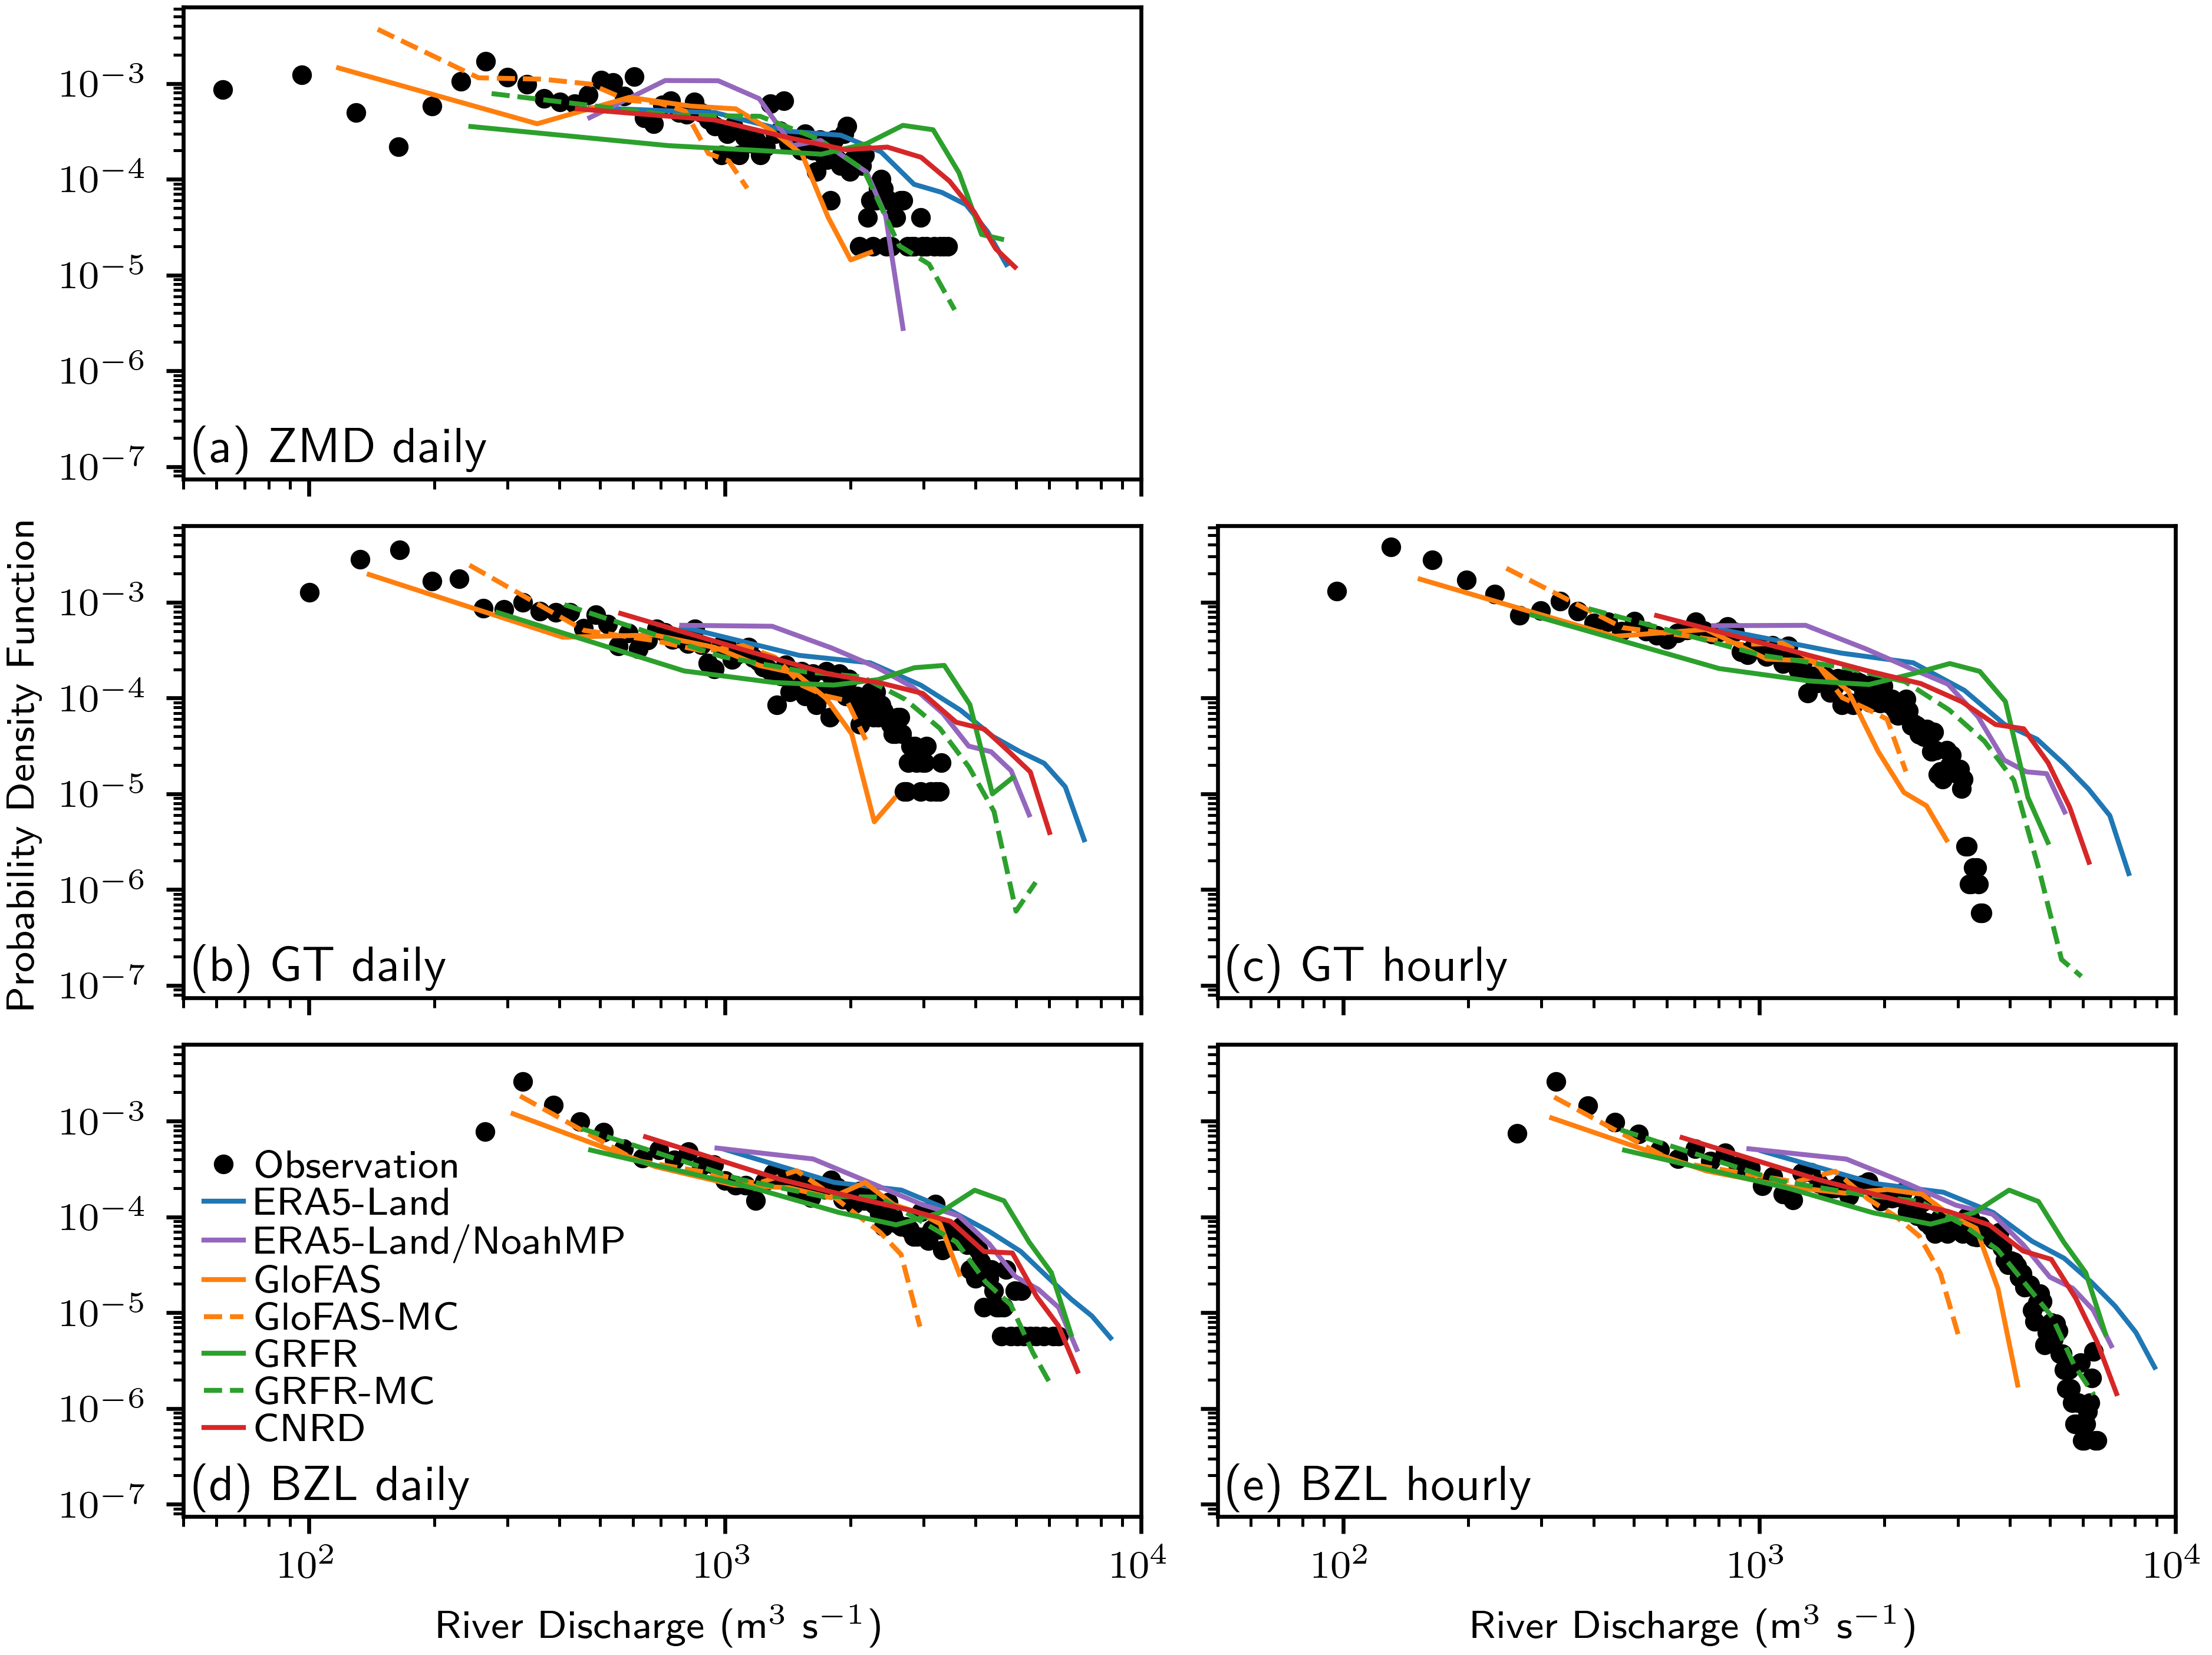

In [25]:
fig = plt.figure(figsize=(16 / 2.54, 12 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 2, sharey=True)

daily_range = (50, 1e4)
hourly_range = (50, 1e4)

ax = axs[0, 0]
station = selected_stations[0]

xyz = (
    qsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(daily_range)
ax.text(
    0.01,
    0.01,
    f"(a) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[0, 1]

xyz = (
    qsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(hourly_range)
ax.text(
    0.01,
    0.01,
    f"(b) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)

ax.set_visible(False)

ax = axs[1, 0]
station = selected_stations[1]

xyz = (
    qsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(daily_range)
ax.set_ylabel("Probability Density Function")
ax.text(
    0.01,
    0.01,
    f"(b) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[1, 1]

xyz = (
    qsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(hourly_range)
ax.text(
    0.01,
    0.01,
    f"(c) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[2, 0]
station = selected_stations[2]

xyz = (
    qsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(daily_range)
ax.set_xlabel("River Discharge (m$^3$ s$^{-1}$)")
ax.text(
    0.01,
    0.01,
    f"(d) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax.legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 0.1),
    frameon=False,
    borderpad=0.02,
    labelspacing=0.05,
    handlelength=1,
    handletextpad=0.3,
)


ax = axs[2, 1]

xyz = (
    qsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(hourly_range)
ax.set_xlabel("River Discharge (m$^3$ s$^{-1}$)")
ax.text(
    0.01,
    0.01,
    f"(e) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


fig.savefig(
    FIGROOT.joinpath("streamflow_dist").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

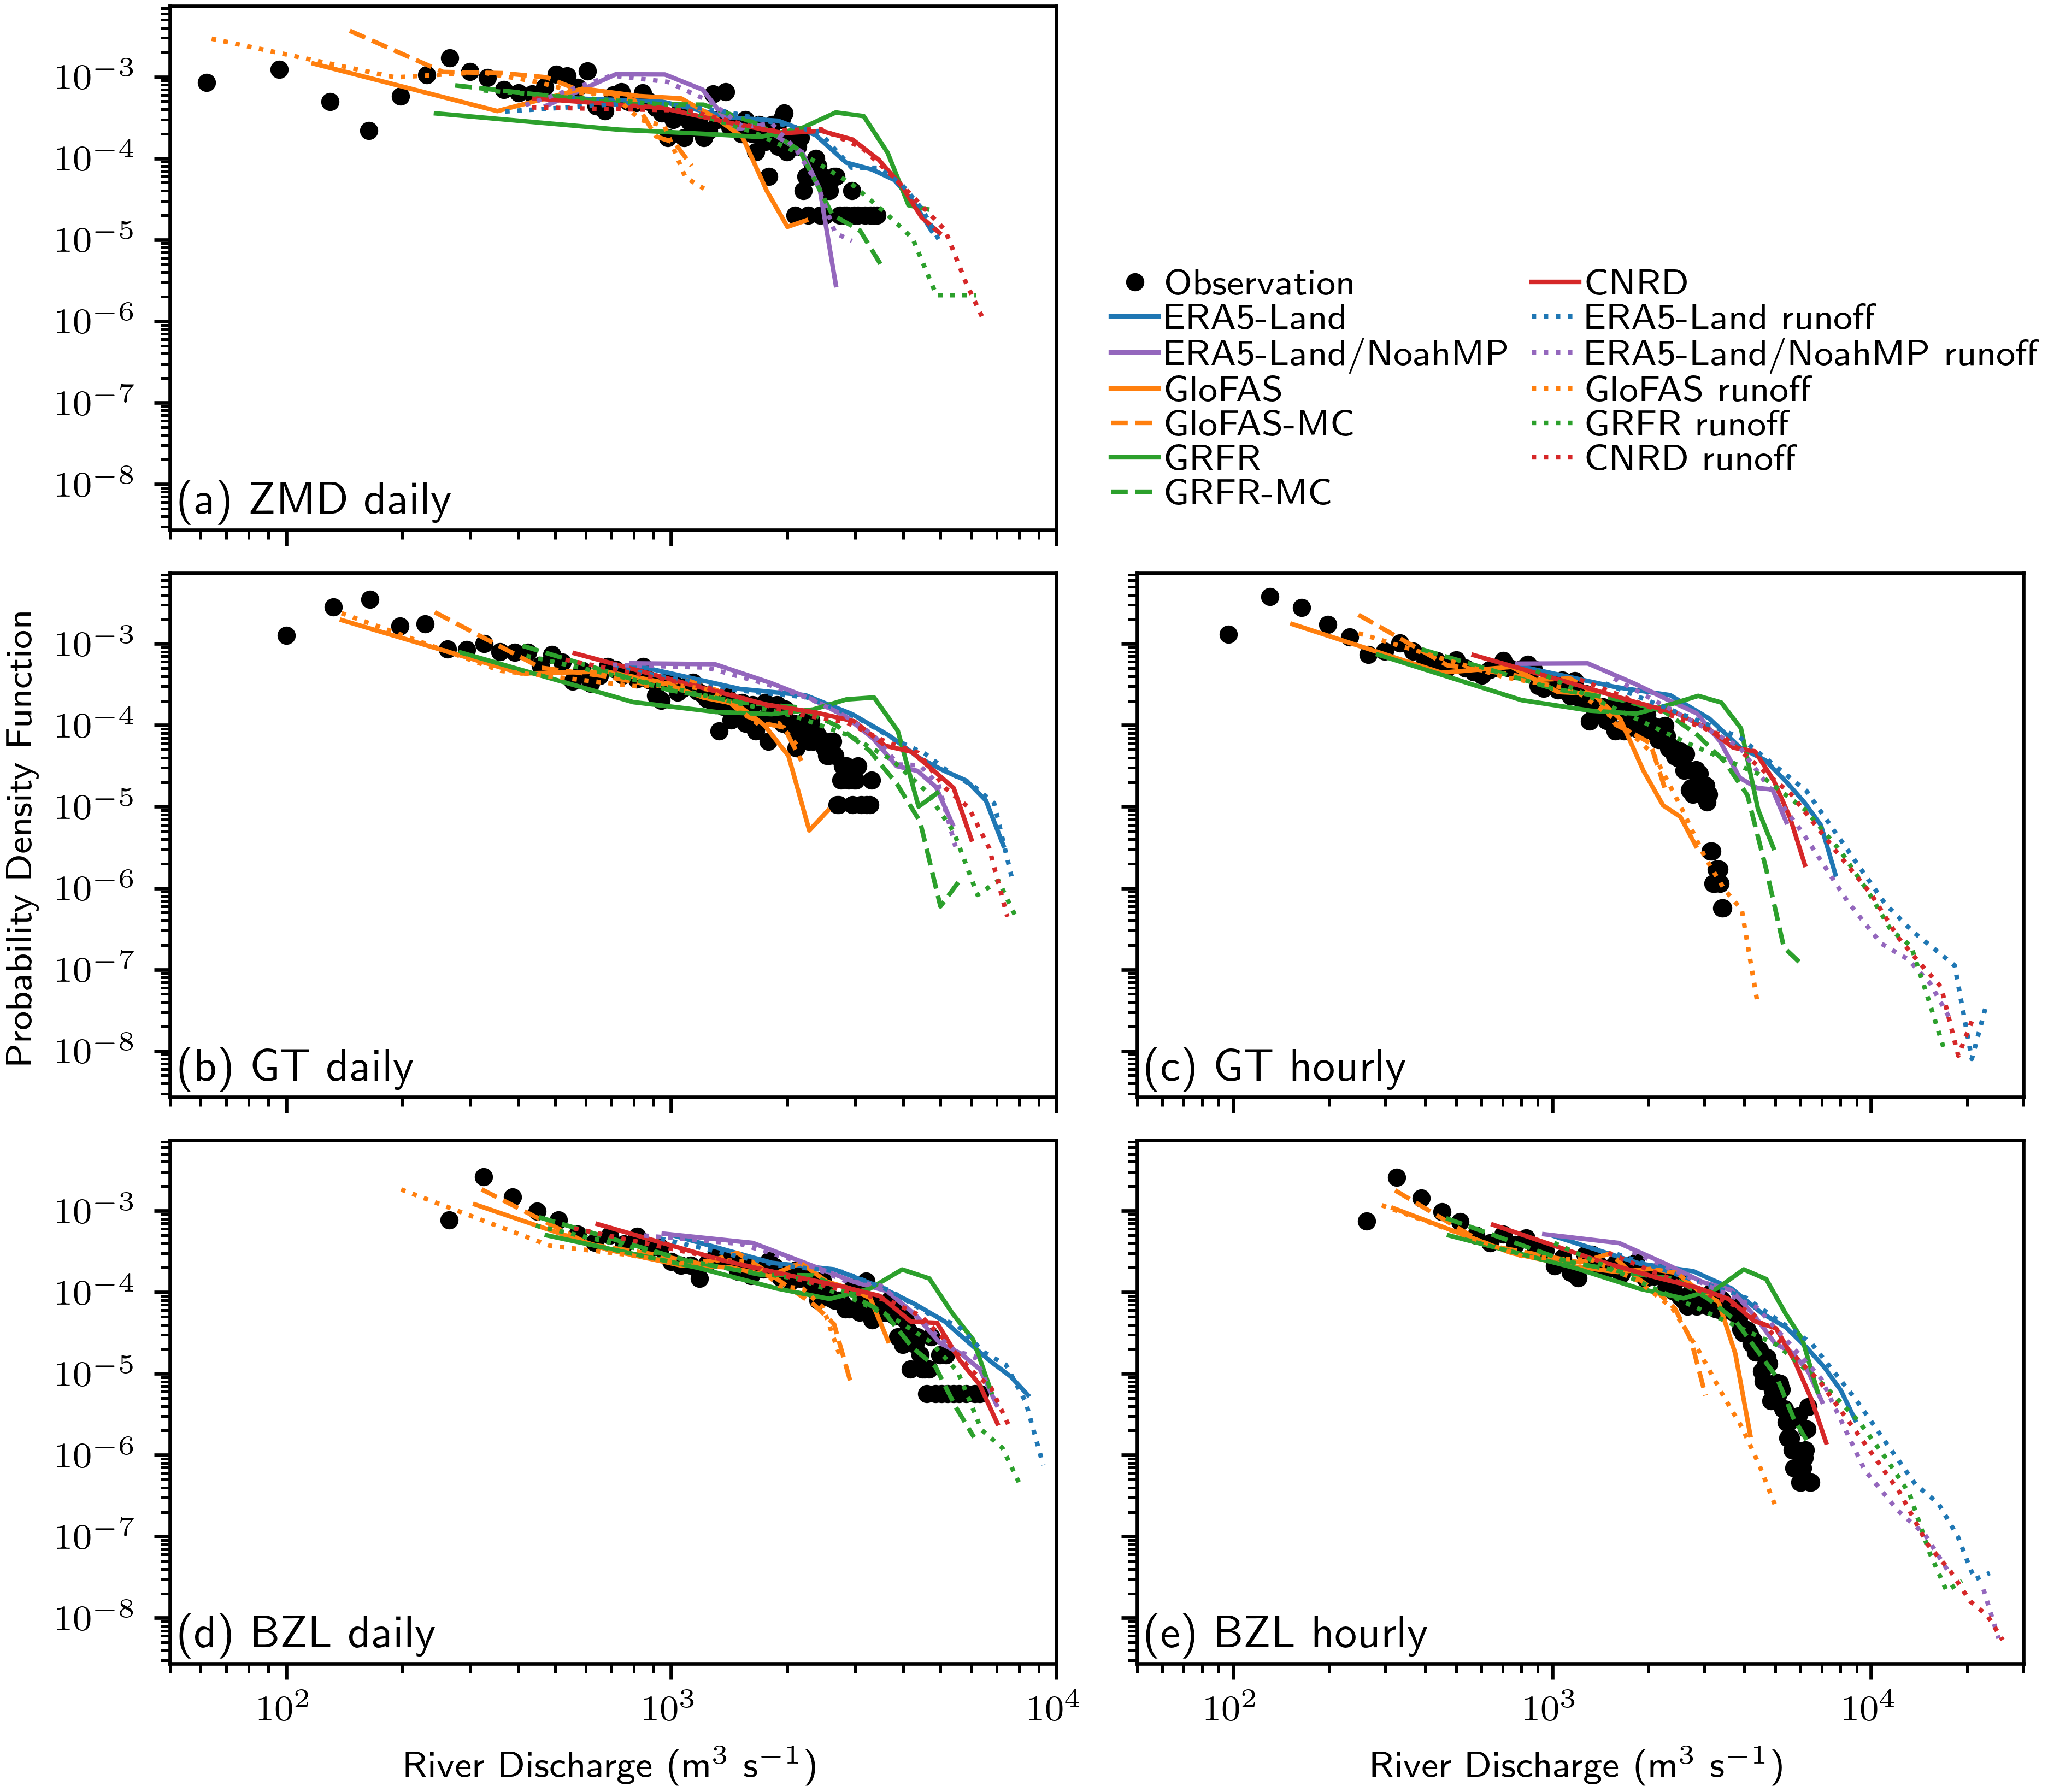

In [26]:
fig = plt.figure(figsize=(16 / 2.54, 14 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 2, sharey=True)

daily_range = (50, 1e4)
hourly_range = (50, 3e4)

ax = axs[0, 0]
station = selected_stations[0]

xyz = (
    qsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )
for dataname, data in rsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=":",
        label=f"{labels[dataname]} runoff",
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(daily_range)
ax.text(
    0.01,
    0.01,
    f"(a) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[0, 1]

ax.plot(np.nan, np.nan, "k.", label="Observation")

for dataname, data in qsim.items():
    ax.plot(
        np.nan,
        np.nan,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )
for dataname, data in rsim.items():
    ax.plot(
        np.nan,
        np.nan,
        lw=1,
        color=linecolors[dataname],
        ls=":",
        label=f"{labels[dataname]} runoff",
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_axis_off()


ax.legend(
    ncols=2,
    loc="lower left",
    bbox_to_anchor=(-0.05, 0.0),
    fontsize=8,
    frameon=False,
    borderpad=0.00,
    labelspacing=0.05,
    handlelength=1.3,
    handletextpad=0.2,
    columnspacing=0.5,
)


ax = axs[1, 0]
station = selected_stations[1]

xyz = (
    qsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )
for dataname, data in rsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=":",
        label=f"{labels[dataname]} runoff",
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(daily_range)
ax.set_ylabel("Probability Density Function")
ax.text(
    0.01,
    0.01,
    f"(b) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[1, 1]

xyz = (
    qsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )
for dataname, data in rsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=":",
        label=f"{labels[dataname]} runoff",
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticklabels("")
ax.set_xlim(hourly_range)
ax.text(
    0.01,
    0.01,
    f"(c) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[2, 0]
station = selected_stations[2]

xyz = (
    qsimday[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )
for dataname, data in rsimday.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobsday.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=":",
        label=f"{labels[dataname]} runoff",
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(daily_range)
ax.set_xlabel("River Discharge (m$^3$ s$^{-1}$)")
ax.text(
    0.01,
    0.01,
    f"(d) {station_pinyin[station]} daily",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


ax = axs[2, 1]

xyz = (
    qsim[list(datanames)[0]]
    .select(pl.col("datetime"), pl.col(station.urn))
    .drop_nulls()
    .join(
        qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
        on="datetime",
        how="inner",
        coalesce=True,
    )
)
yy, xx = np.histogram(
    xyz[:, 2],
    bins=100,
    density=True,
)
xx = (xx[:-1] + xx[1:]) / 2
ax.plot(xx, yy, "k.", label="Observation")

for dataname, data in qsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=linestyles[dataname],
        label=labels[dataname],
    )
for dataname, data in rsim.items():
    xyz = (
        data.select(pl.col("datetime"), pl.col(station.urn))
        .drop_nulls()
        .join(
            qobs.select(pl.col("datetime"), pl.col(station.urn)).drop_nulls(),
            on="datetime",
            how="inner",
            coalesce=True,
        )
    )
    yy, xx = np.histogram(
        xyz[:, 1],
        density=True,
    )
    xx = (xx[:-1] + xx[1:]) / 2
    yy[yy < 1e-9] = np.nan
    ax.plot(
        xx,
        yy,
        lw=1,
        color=linecolors[dataname],
        ls=":",
        label=f"{labels[dataname]} runoff",
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(hourly_range)
ax.set_xlabel("River Discharge (m$^3$ s$^{-1}$)")
ax.text(
    0.01,
    0.01,
    f"(e) {station_pinyin[station]} hourly",
    ha="left",
    va="bottom",
    transform=ax.transAxes,
)


fig.savefig(
    FIGROOT.joinpath("streamflow_runoff_dist").with_suffix(FIGSUFFIX),
    bbox_inches="tight",
)

## Skill Metrics

In [38]:
def kge(obs: pl.DataFrame, sim: pl.DataFrame):
    assert set(obs.columns) == set(sim.columns)
    assert "datetime" in obs.columns
    assert "datetime" in sim.columns
    cols = list(obs.columns[1:])
    obssim = obs.join(sim, on="datetime", how="inner", coalesce=True).drop_nulls()
    mean_obs = {col: float(obssim[col].mean()) for col in cols}
    mean_sim = {col: float(obssim[col + "_right"].mean()) for col in cols}
    std_obs = {col: float(obssim[col].std()) for col in cols}
    std_sim = {col: float(obssim[col + "_right"].std()) for col in cols}
    r = {
        col: float(np.corrcoef(obssim[col], obssim[col + "_right"])[0, 1])
        for col in cols
    }
    g1 = {col: (r[col] - 1) ** 2 for col in cols}
    g2 = {col: (std_sim[col] / std_obs[col] - 1) ** 2 for col in cols}
    g3 = {col: (mean_sim[col] / mean_obs[col] - 1) ** 2 for col in cols}
    gs = {col: g1[col] + g2[col] + g3[col] for col in cols}
    return (
        {UUID(col): 1 - math.sqrt(gs[col]) for col in cols},
        {UUID(col): g1[col] / gs[col] for col in cols},
        {UUID(col): g2[col] / gs[col] for col in cols},
        {UUID(col): g3[col] / gs[col] for col in cols},
    )


In [39]:
def corr(obs: pl.DataFrame, sim: pl.DataFrame):
    assert set(obs.columns) == set(sim.columns)
    assert "datetime" in obs.columns
    assert "datetime" in sim.columns
    cols = list(obs.columns[1:])
    obssim = obs.join(sim, on="datetime", how="inner", coalesce=True).drop_nulls()
    r = {
        col: float(np.corrcoef(obssim[col], obssim[col + "_right"])[0, 1])
        for col in cols
    }
    return {UUID(col): r[col] for col in cols}

In [40]:
emon = {}
g1mon = {}
g2mon = {}
g3mon = {}
corrmon = {}
for dataname, data in qsimmon.items():
    emon[dataname], g1mon[dataname], g2mon[dataname], g3mon[dataname] = kge(
        qobsmon, data
    )
    corrmon[dataname] = corr(qobsmon, data)

In [41]:
eday = {}
g1day = {}
g2day = {}
g3day = {}
qcorrday = {}
for dataname, data in qsimday.items():
    eday[dataname], g1day[dataname], g2day[dataname], g3day[dataname] = kge(
        qobsday, data
    )
    qcorrday[dataname] = corr(qobsday, data)

In [42]:
ehour = {}
g1hour = {}
g2hour = {}
g3hour = {}
qcorrhour = {}
for dataname, data in qsim.items():
    ehour[dataname], g1hour[dataname], g2hour[dataname], g3hour[dataname] = kge(
        qobs, data
    )
    qcorrhour[dataname] = corr(qobs, data)

In [43]:
ermon = {}
g1rmon = {}
g2rmon = {}
g3rmon = {}
rcorrmon = {}
for dataname, data in rsimmon.items():
    ermon[dataname], g1rmon[dataname], g2rmon[dataname], g3rmon[dataname] = kge(
        qobsmon, data
    )
    rcorrmon[dataname] = corr(qobsmon, data)

In [44]:
erday = {}
g1rday = {}
g2rday = {}
g3rday = {}
rcorrday = {}
for dataname, data in rsimday.items():
    erday[dataname], g1rday[dataname], g2rday[dataname], g3rday[dataname] = kge(
        qobsday, data
    )
    rcorrday[dataname] = corr(qobsday, data)

In [45]:
erhour = {}
g1rhour = {}
g2rhour = {}
g3rhour = {}
rcorrhour = {}
for dataname, data in rsim.items():
    erhour[dataname], g1rhour[dataname], g2rhour[dataname], g3rhour[dataname] = kge(
        qobs, data
    )
    rcorrhour[dataname] = corr(qobs, data)

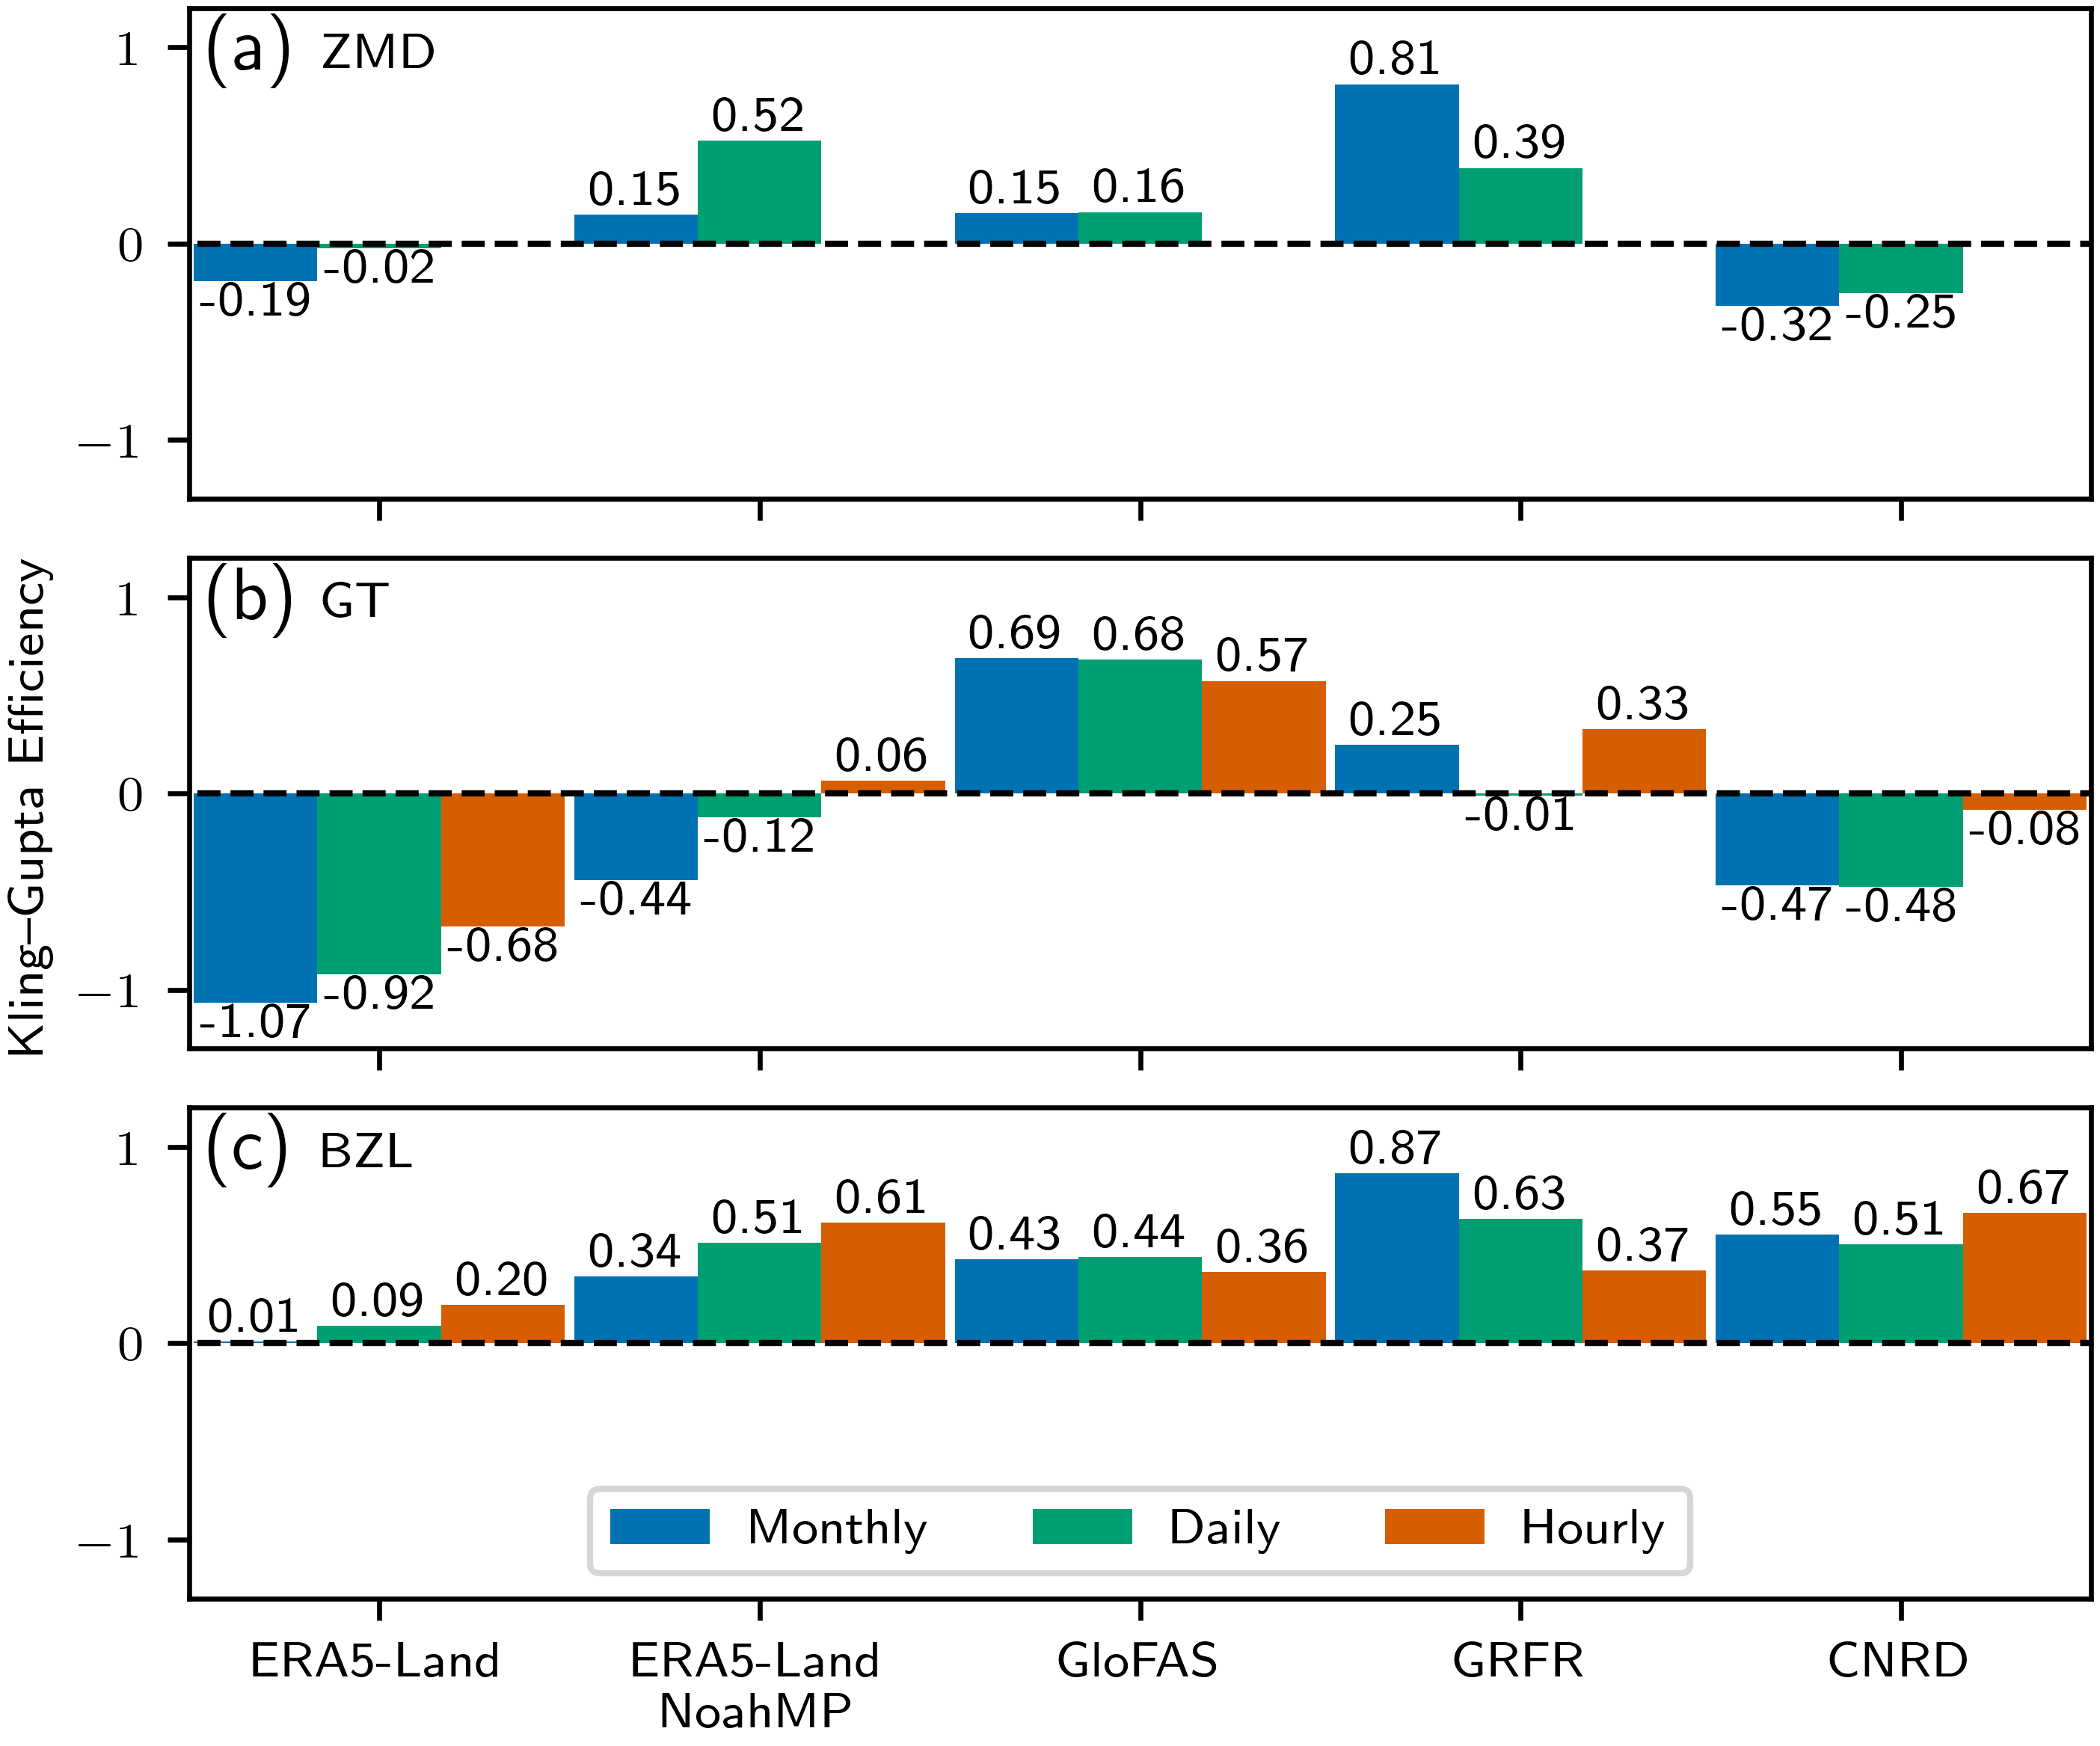

In [34]:
fig = plt.figure(figsize=(12 / 2.54, 10 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 1, squeeze=False, sharex=True, sharey=True)

barwidth = 0.325

ax = axs[0, 0]

station = selected_stations[0]
xx = {labels[y]: ermon[y][station] for y in rsim.keys()}
yy = {labels[y]: erday[y][station] for y in rsim.keys()}
baroffset = -barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    yy.values(),
    width=barwidth,
    label="Daily",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    float("nan"),
    width=barwidth,
    label="Hourly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.text(0.01, 0.99, "(a)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.07, 0.88, "ZMD", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax = axs[1, 0]

station = selected_stations[1]
xx = {labels[y]: ermon[y][station] for y in rsim.keys()}
yy = {labels[y]: erday[y][station] for y in rsim.keys()}
zz = {labels[y]: erhour[y][station] for y in rsim.keys()}
baroffset = -barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    yy.values(),
    width=barwidth,
    label="Daily",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(zz))],
    zz.values(),
    width=barwidth,
    label="Hourly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.set_ylabel("Kling--Gupta Efficiency")
ax.text(0.01, 0.99, "(b)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.07, 0.88, "GT", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax = axs[2, 0]

station = selected_stations[2]
xx = {labels[y]: ermon[y][station] for y in rsim.keys()}
yy = {labels[y]: erday[y][station] for y in rsim.keys()}
zz = {labels[y]: erhour[y][station] for y in rsim.keys()}
baroffset = -barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    yy.values(),
    width=barwidth,
    label="Daily",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(zz))],
    zz.values(),
    width=barwidth,
    label="Hourly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(rsim.keys())], [0, 0], "k--", lw=1)
ax.text(0.01, 0.99, "(c)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.07, 0.88, "BZL", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax.set_xticks([ii for ii in range(len(rsim.keys()))])
ax.set_xticklabels([labels[x].replace("/", "\n") for x in rsim.keys()])

ax.set_xlim(left=-0.5)
ax.set_xlim(right=len(rsim.keys()) - 0.5)
ax.set_ylim(-1.3, 1.2)

ax.legend(loc="lower center", ncols=3)

fig.savefig(
    FIGROOT.joinpath("runoff_agg_kge").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

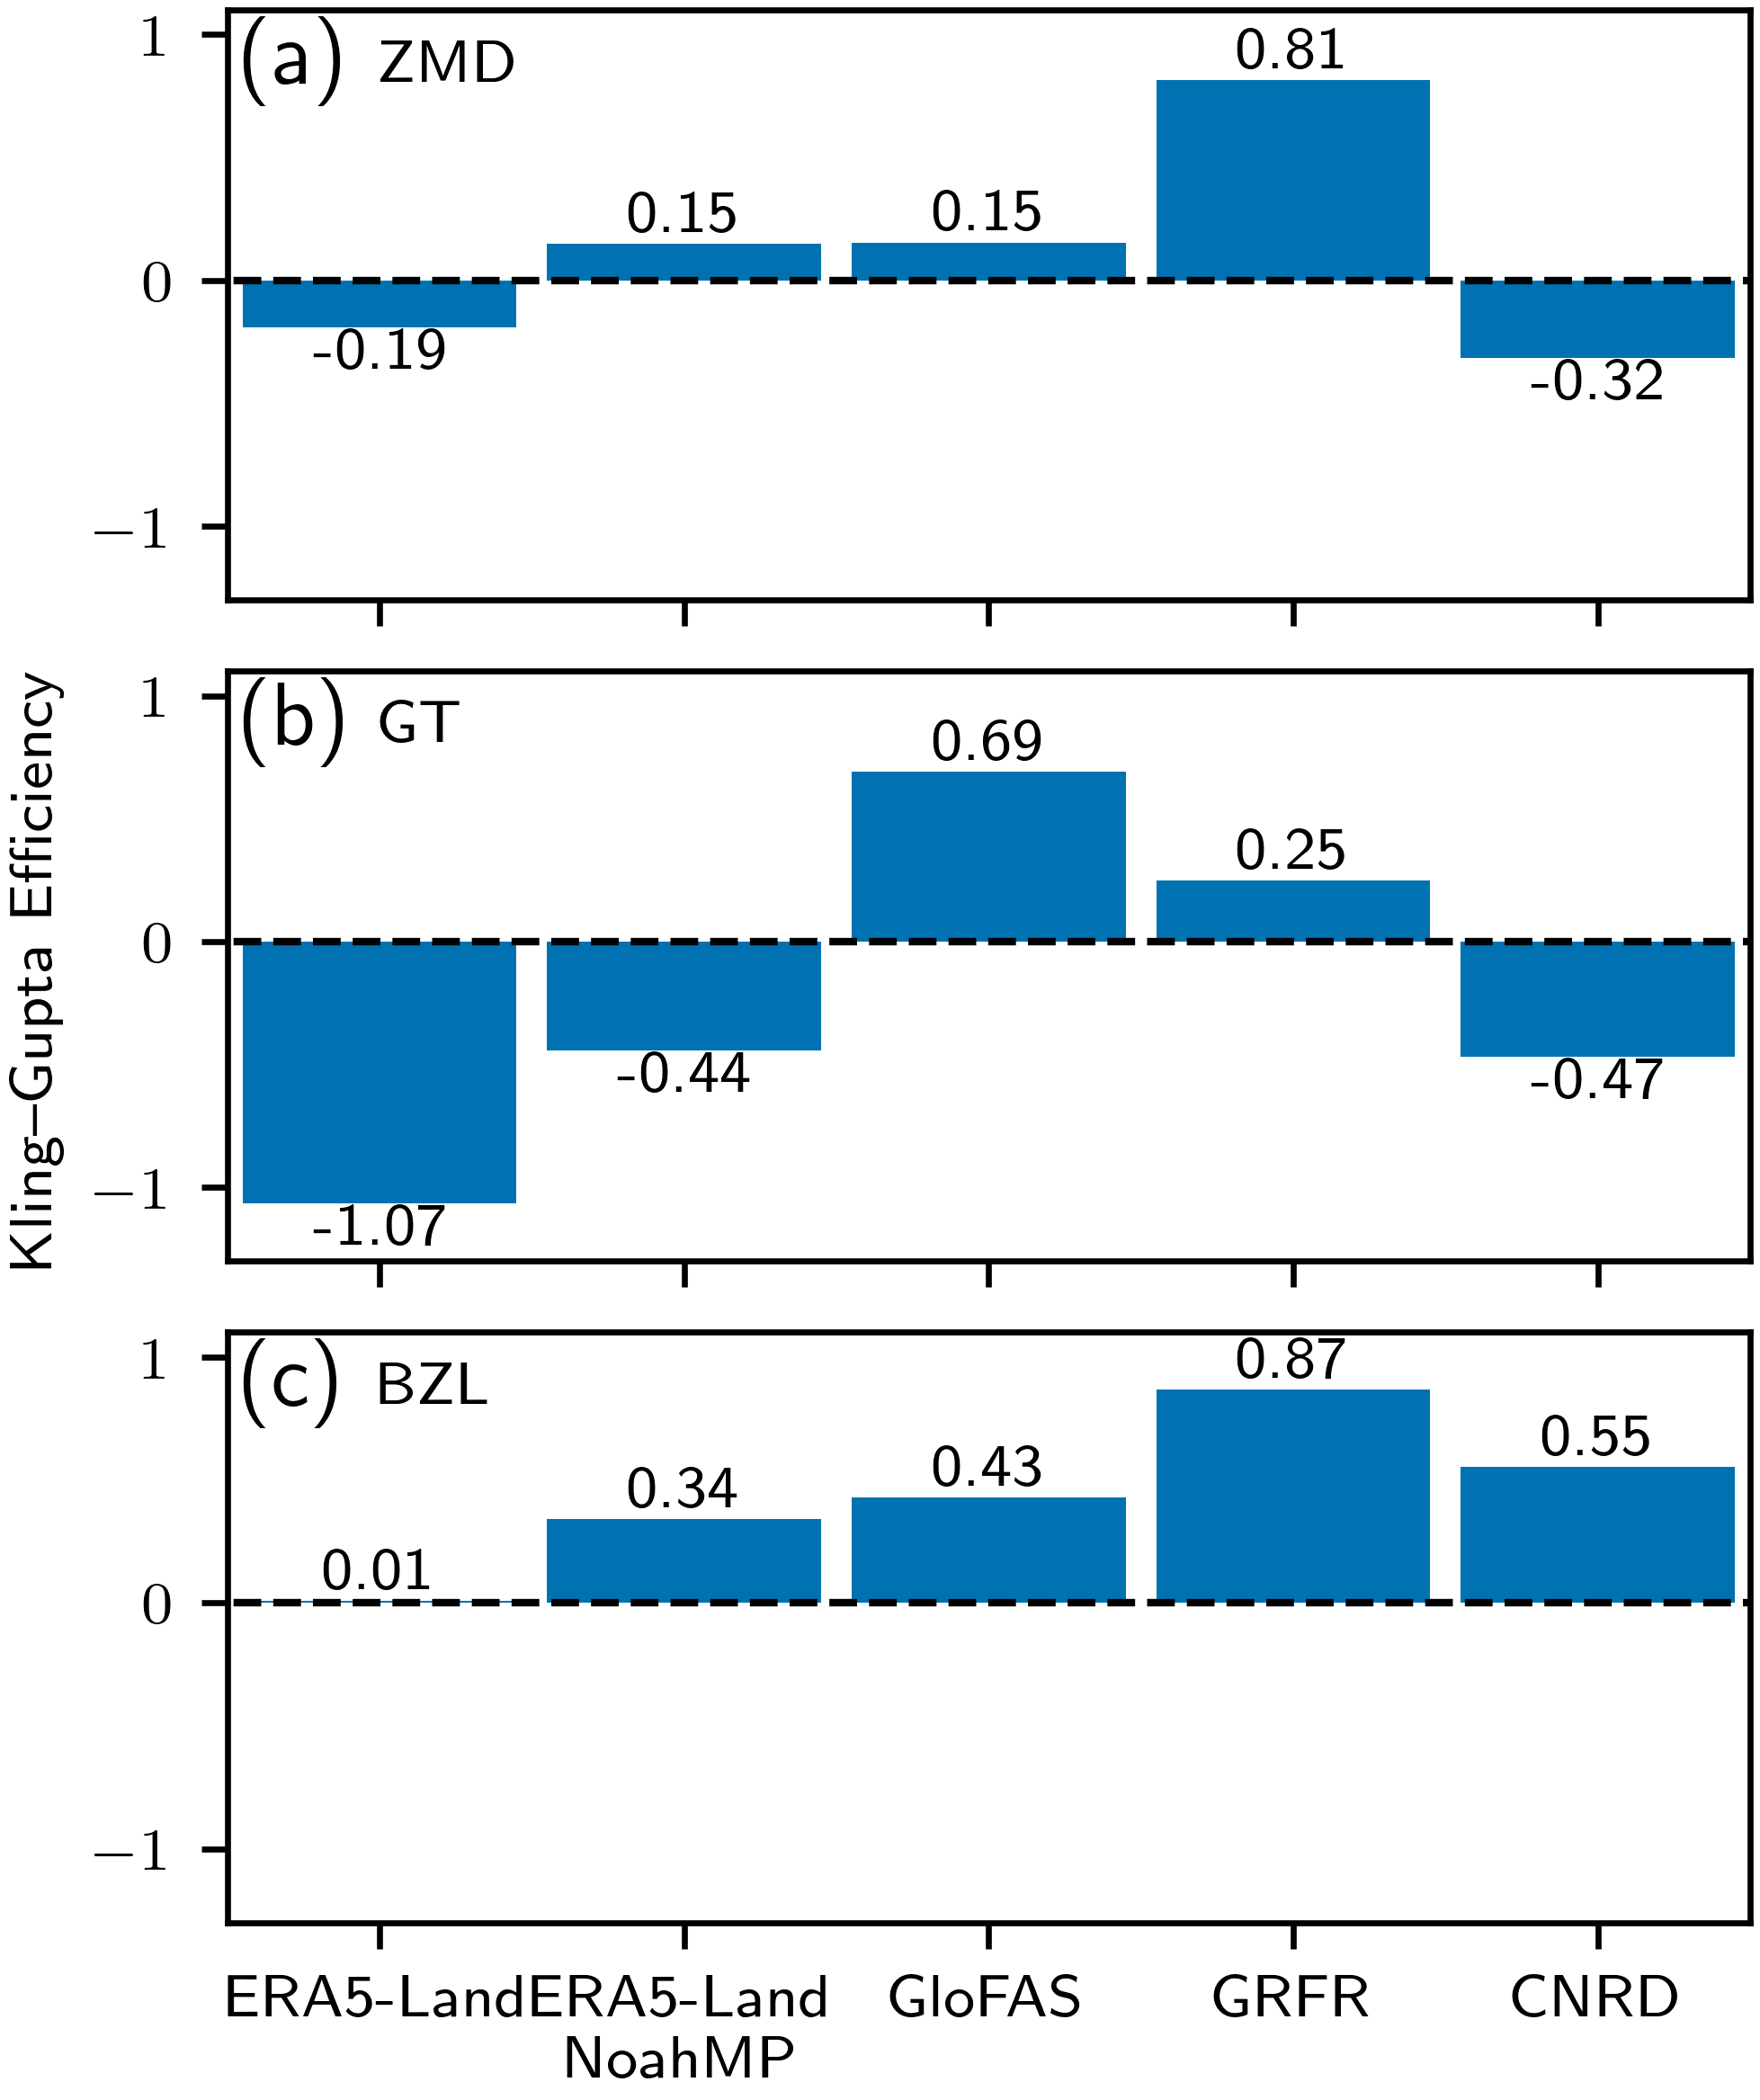

In [35]:
fig = plt.figure(figsize=(8.4 / 2.54, 10 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 1, squeeze=False, sharex=True, sharey=True)

barwidth = 0.9

ax = axs[0, 0]

station = selected_stations[0]
xx = {labels[y]: ermon[y][station] for y in rsim.keys()}
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.text(0.01, 0.99, "(a)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.10, 0.88, "ZMD", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax = axs[1, 0]

station = selected_stations[1]
xx = {labels[y]: ermon[y][station] for y in rsim.keys()}
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.set_ylabel("Kling--Gupta Efficiency")
ax.text(0.01, 0.99, "(b)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.10, 0.88, "GT", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax = axs[2, 0]

station = selected_stations[2]
xx = {labels[y]: ermon[y][station] for y in rsim.keys()}
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(rsim.keys())], [0, 0], "k--", lw=1)
ax.text(0.01, 0.99, "(c)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.1, 0.88, "BZL", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax.set_xticks([ii for ii in range(len(rsim.keys()))])
ax.set_xticklabels([labels[x].replace("/", "\n") for x in rsim.keys()])

ax.set_xlim(left=-0.5)
ax.set_xlim(right=len(rsim.keys()) - 0.5)
ax.set_ylim(-1.3, 1.1)


fig.savefig(
    FIGROOT.joinpath("runoff_agg_kge_mon").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

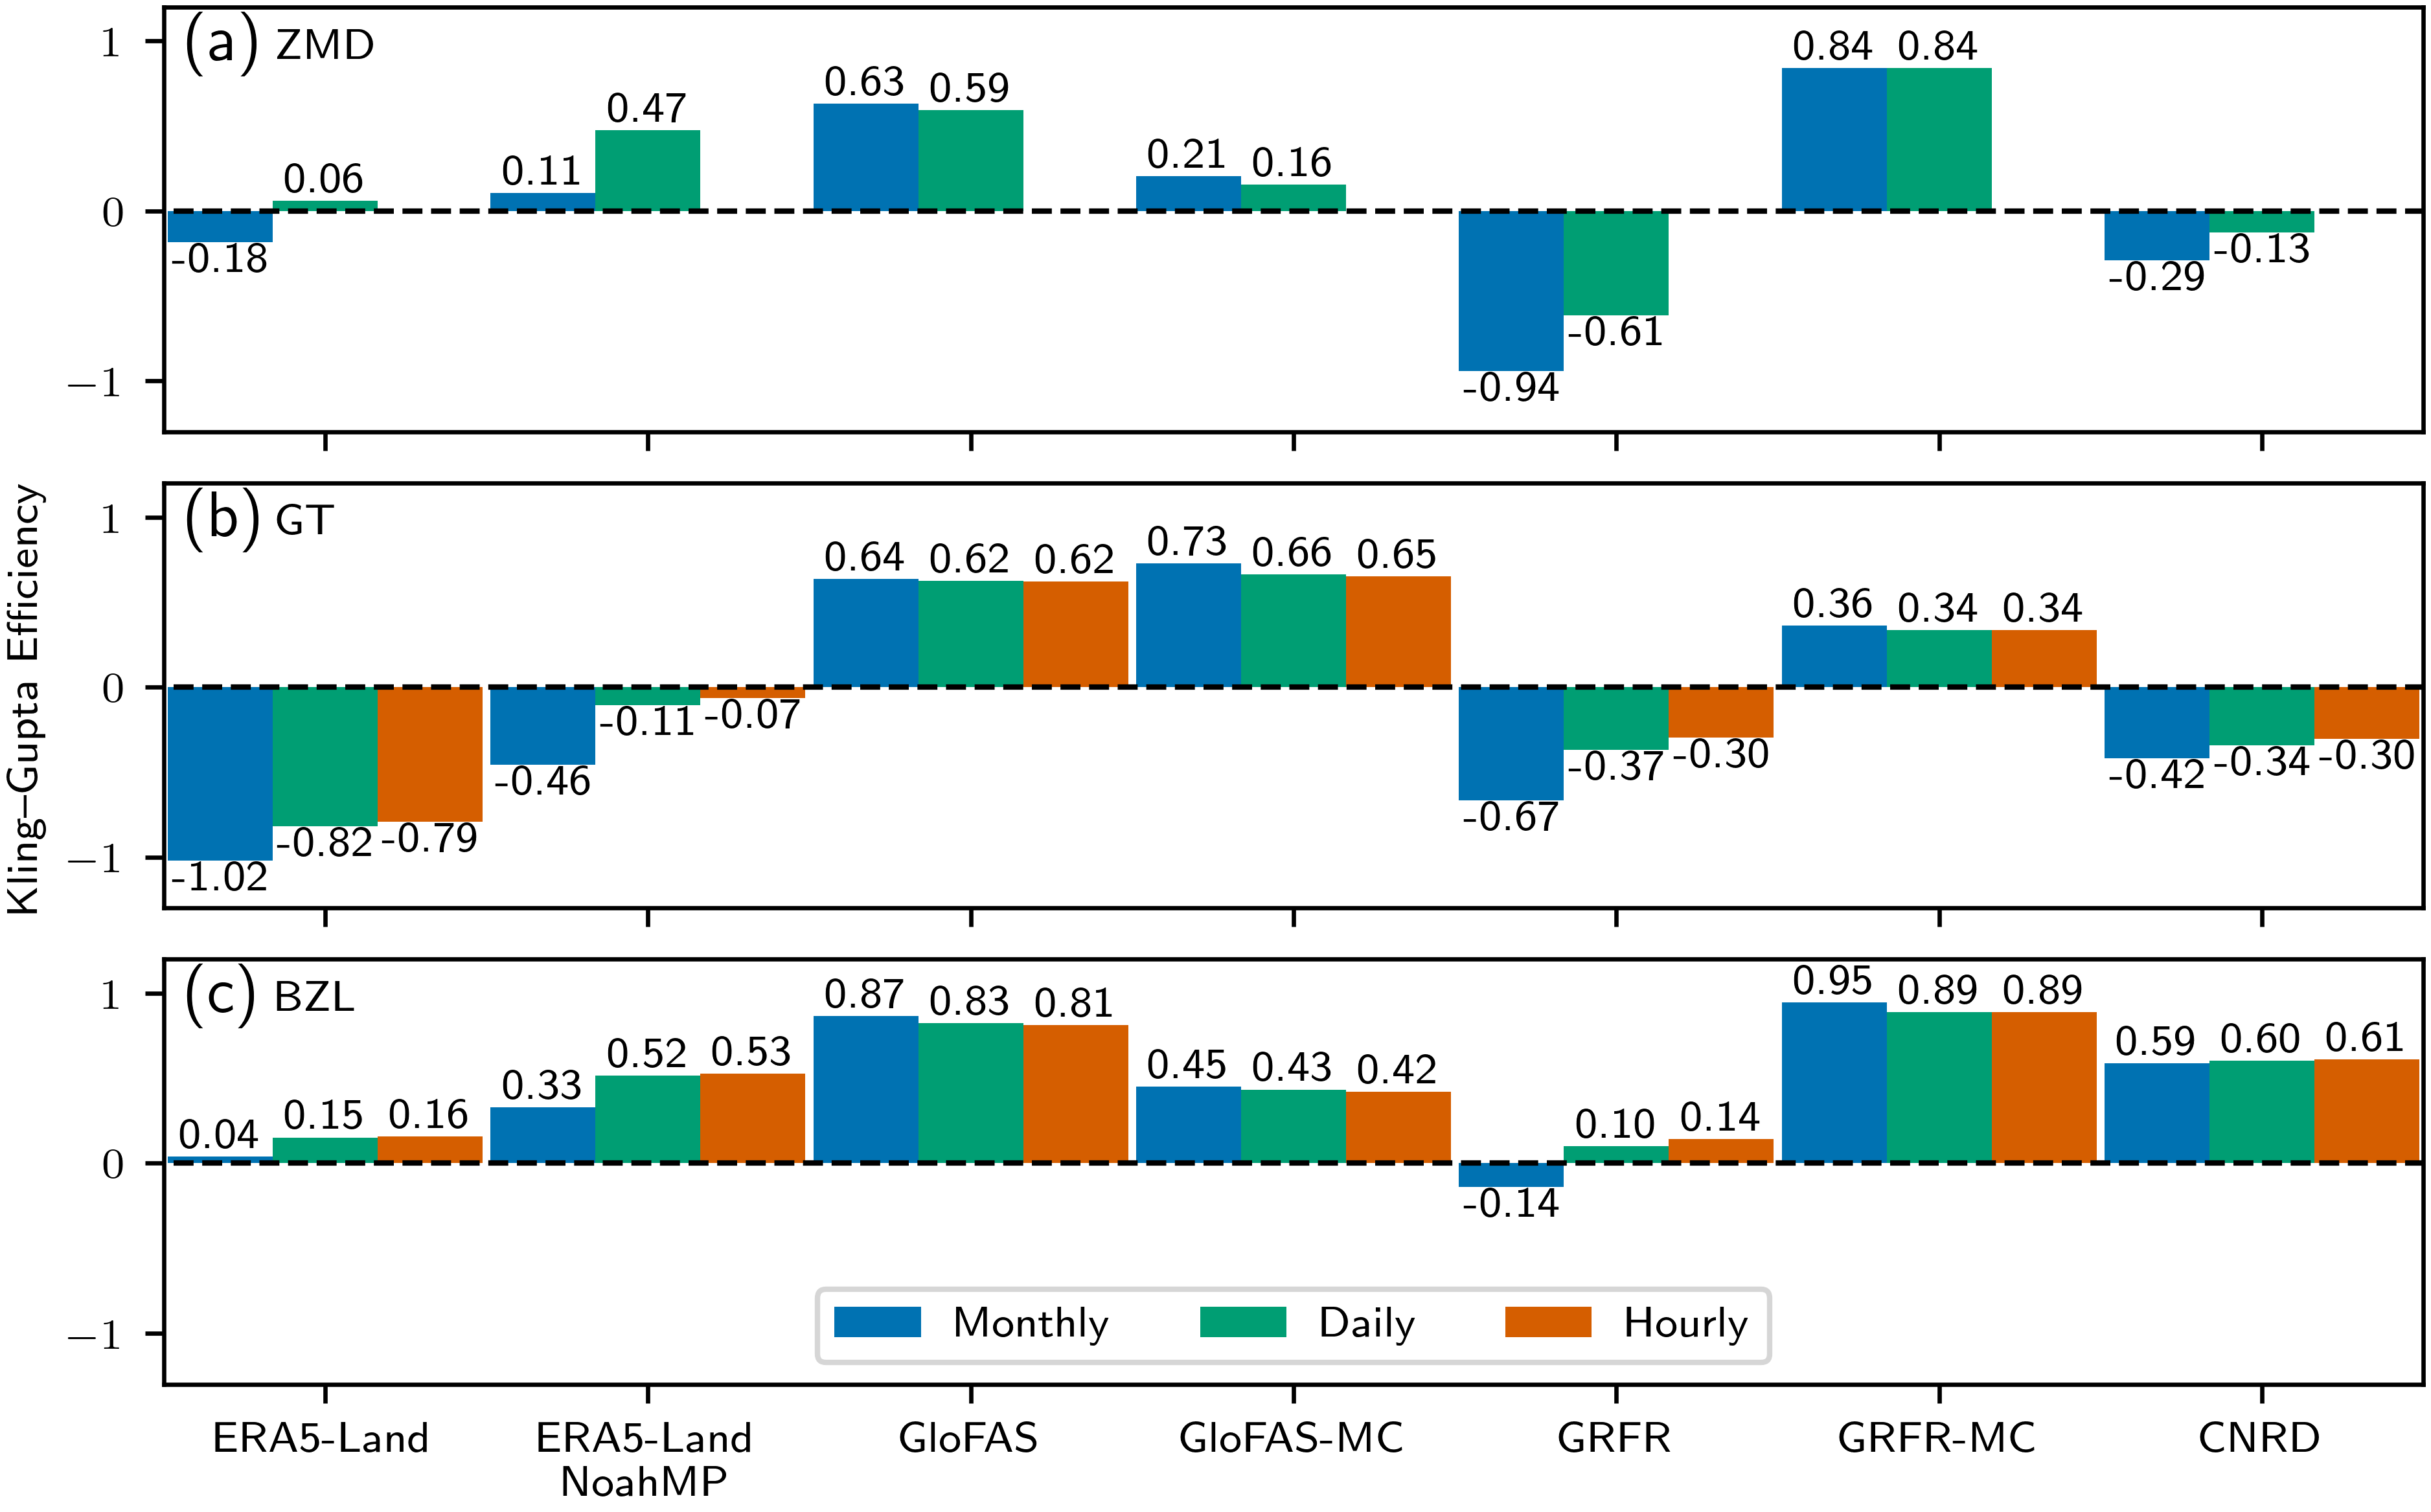

In [36]:
fig = plt.figure(figsize=(16 / 2.54, 10 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(3, 1, squeeze=False, sharex=True, sharey=True)

barwidth = 0.325

ax = axs[0, 0]

station = selected_stations[0]
xx = {labels[y]: emon[y][station] for y in datanames}
yy = {labels[y]: eday[y][station] for y in datanames}
baroffset = -barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    yy.values(),
    width=barwidth,
    label="Daily",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    float("nan"),
    width=barwidth,
    label="Hourly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.text(0.01, 0.99, "(a)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.05, 0.88, "ZMD", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax = axs[1, 0]

station = selected_stations[1]
xx = {labels[y]: emon[y][station] for y in datanames}
yy = {labels[y]: eday[y][station] for y in datanames}
zz = {labels[y]: ehour[y][station] for y in datanames}
baroffset = -barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    yy.values(),
    width=barwidth,
    label="Daily",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(zz))],
    zz.values(),
    width=barwidth,
    label="Hourly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.set_ylabel("Kling--Gupta Efficiency")
ax.text(0.01, 0.99, "(b)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.05, 0.88, "GT", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax = axs[2, 0]

station = selected_stations[2]
xx = {labels[y]: emon[y][station] for y in datanames}
yy = {labels[y]: eday[y][station] for y in datanames}
zz = {labels[y]: ehour[y][station] for y in datanames}
baroffset = -barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(xx))],
    xx.values(),
    width=barwidth,
    label="Monthly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = 0
rects = ax.bar(
    [ii + baroffset for ii in range(len(yy))],
    yy.values(),
    width=barwidth,
    label="Daily",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
baroffset = barwidth
rects = ax.bar(
    [ii + baroffset for ii in range(len(zz))],
    zz.values(),
    width=barwidth,
    label="Hourly",
)
ax.bar_label(rects, fmt="%.2f", fontsize=8)
ax.plot([-1, len(datanames)], [0, 0], "k--", lw=1)
ax.text(0.01, 0.99, "(c)", fontsize=12, ha="left", va="top", transform=ax.transAxes)
ax.text(0.05, 0.88, "BZL", fontsize=8, ha="left", va="baseline", transform=ax.transAxes)

ax.set_xticks([ii for ii in range(len(datanames))])
ax.set_xticklabels([labels[x].replace("/", "\n") for x in datanames])

ax.set_xlim(left=-0.5)
ax.set_xlim(right=len(datanames) - 0.5)
ax.set_ylim(-1.3, 1.2)

ax.legend(loc="lower center", ncols=3)

fig.savefig(
    FIGROOT.joinpath("streamflow_kge").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

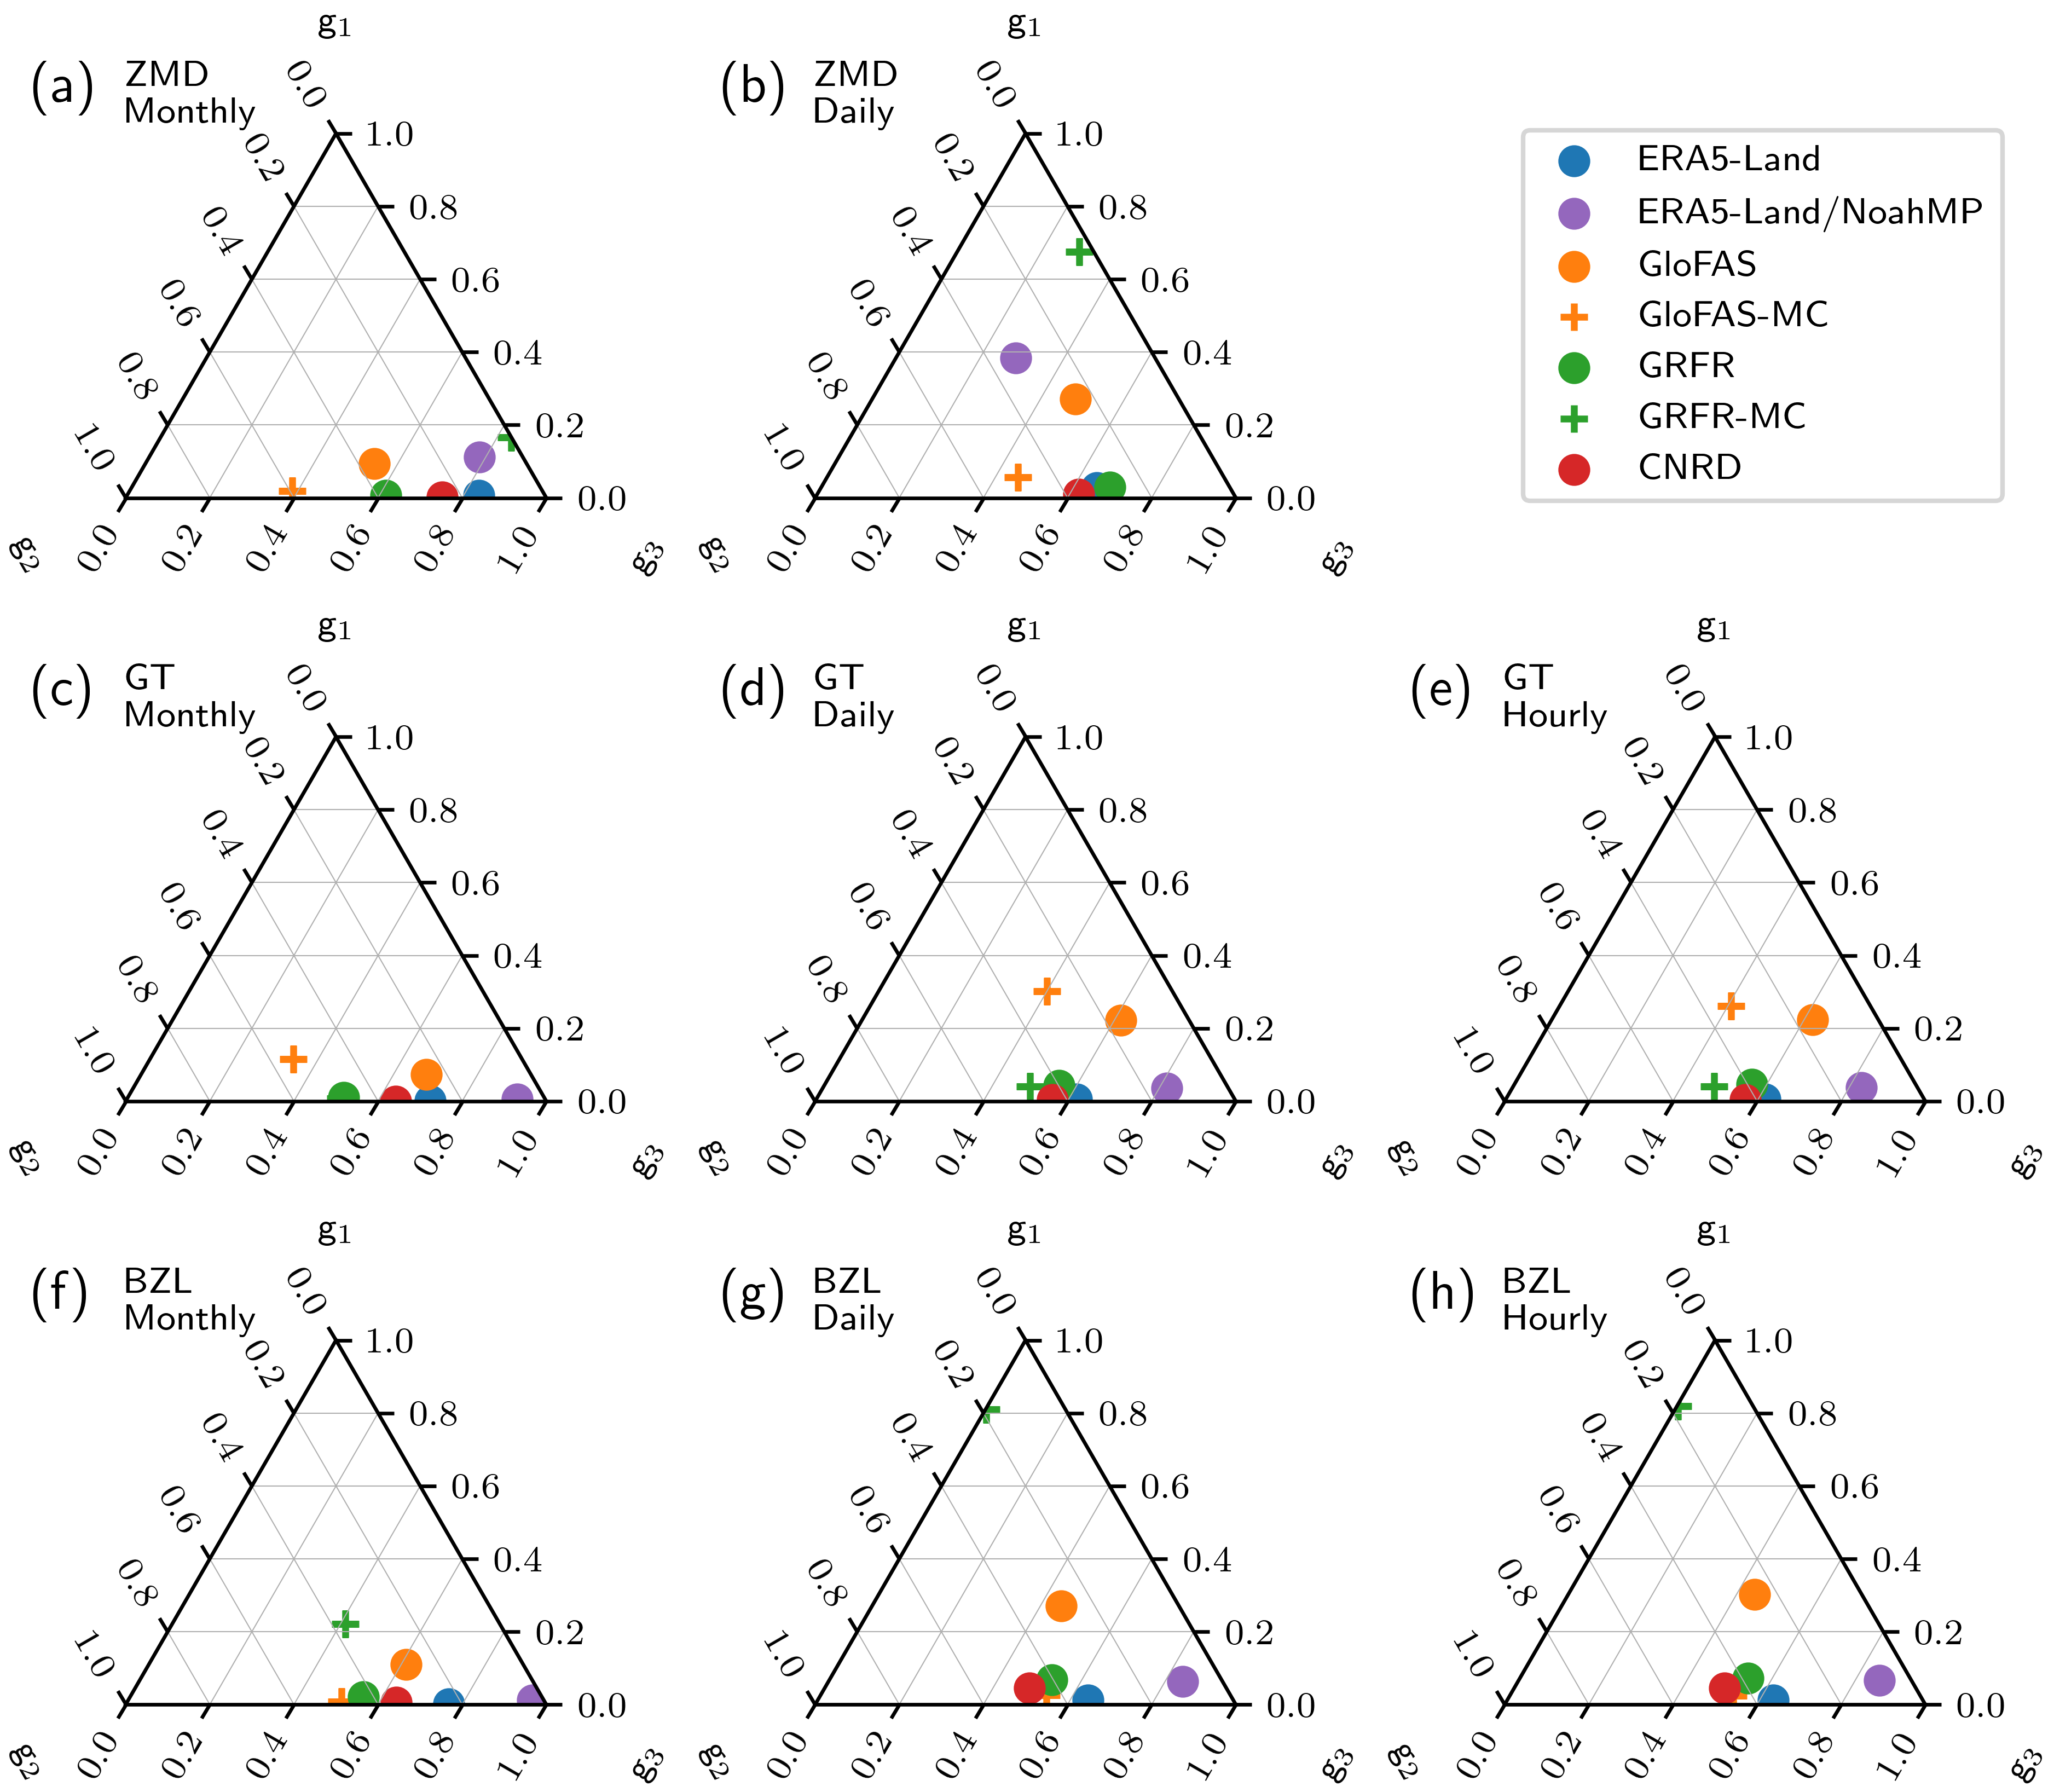

In [37]:
fig = plt.figure(figsize=(16 / 2.54, 14 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(
    3, 3, sharex=True, sharey=True, subplot_kw=dict(projection="ternary")
)

station = selected_stations[0]

ax = axs[0, 0]
for dataname in datanames:
    ax.scatter(
        g1mon[dataname][station],
        g2mon[dataname][station],
        g3mon[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(a)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Monthly",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[0, 1]
for dataname in datanames:
    ax.scatter(
        g1day[dataname][station],
        g2day[dataname][station],
        g3day[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(b)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Daily",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)

ax = axs[0, 2]
for dataname in datanames:
    ax.scatter(
        float("nan"),
        float("nan"),
        float("nan"),
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.set_axis_off()
ax.legend(loc="center left")


station = selected_stations[1]

ax = axs[1, 0]
for dataname in datanames:
    ax.scatter(
        g1mon[dataname][station],
        g2mon[dataname][station],
        g3mon[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(c)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Monthly",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[1, 1]
for dataname in datanames:
    ax.scatter(
        g1day[dataname][station],
        g2day[dataname][station],
        g3day[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(d)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Daily",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)

ax = axs[1, 2]
for dataname in datanames:
    ax.scatter(
        g1hour[dataname][station],
        g2hour[dataname][station],
        g3hour[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(e)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Hourly",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)


station = selected_stations[2]

ax = axs[2, 0]
for dataname in datanames:
    ax.scatter(
        g1mon[dataname][station],
        g2mon[dataname][station],
        g3mon[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(f)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Monthly",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)


ax = axs[2, 1]
for dataname in datanames:
    ax.scatter(
        g1day[dataname][station],
        g2day[dataname][station],
        g3day[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(g)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Daily",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)

ax = axs[2, 2]
for dataname in datanames:
    ax.scatter(
        g1hour[dataname][station],
        g2hour[dataname][station],
        g3hour[dataname][station],
        marker=markerstyles[dataname],
        color=linecolors[dataname],
        label=labels[dataname],
    )
ax.grid()
ax.set_tlabel("g$_1$")
ax.set_llabel("g$_2$")
ax.set_rlabel("g$_3$")
ax.text(
    -0.22,
    1.2,
    "(h)",
    fontsize=12,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    0.0,
    1.2,
    f"{station_pinyin[station]}\n Hourly",
    fontsize=8,
    ha="left",
    va="top",
    transform=ax.transAxes,
)

fig.savefig(
    FIGROOT.joinpath("streamflow_kge_comp").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

In [65]:
qobs2 = qobs.drop_nulls(UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0").urn)
qobs2mon = qobs2.group_by_dynamic(
    "datetime",
    every="1mo",
    period="1mo",
    closed="right",
    label="left",
).agg(pl.all().exclude("datetime").mean())
qobs2day = qobs2.group_by_dynamic(
    "datetime",
    every="1d",
    period="1d",
    closed="right",
    label="left",
).agg(pl.all().exclude("datetime").mean())

In [66]:
e2mon = {}
g21mon = {}
g22mon = {}
g23mon = {}
corr2mon = {}
for dataname, data in qsimmon.items():
    e2mon[dataname], g21mon[dataname], g22mon[dataname], g23mon[dataname] = kge(
        qobs2mon, data
    )
    corr2mon[dataname] = corr(qobs2mon, data)

In [67]:
e2mon

{'era5l': {UUID('e4ff26a2-3871-481a-9a83-d43847596bb0'): -0.18374736463710706,
  UUID('2947afef-51b6-4b02-82f7-995d12185682'): -1.0136680155771756,
  UUID('ac5b1300-c6ee-4395-a285-d77c6b3a1c95'): 0.6964046097337632,
  UUID('50cc5dfb-734f-4e67-a8f5-4095d0d72e85'): 0.021272359615790437},
 'era5lnmp': {UUID('e4ff26a2-3871-481a-9a83-d43847596bb0'): 0.10718420464719525,
  UUID('2947afef-51b6-4b02-82f7-995d12185682'): -0.4580202370827835,
  UUID('ac5b1300-c6ee-4395-a285-d77c6b3a1c95'): 0.4882593023292996,
  UUID('50cc5dfb-734f-4e67-a8f5-4095d0d72e85'): 0.31077070212427993},
 'glofas': {UUID('e4ff26a2-3871-481a-9a83-d43847596bb0'): 0.6318108543528609,
  UUID('2947afef-51b6-4b02-82f7-995d12185682'): 0.6324535975094511,
  UUID('ac5b1300-c6ee-4395-a285-d77c6b3a1c95'): -0.4446304664635228,
  UUID('50cc5dfb-734f-4e67-a8f5-4095d0d72e85'): 0.8686143359830464},
 'glofas-mc': {UUID('e4ff26a2-3871-481a-9a83-d43847596bb0'): 0.20669537714210395,
  UUID('2947afef-51b6-4b02-82f7-995d12185682'): 0.719224639